# LAB: Multimodal Learning WSI + Genomics
Authors:
- Vittorio Pipoli (vittorio.pipoli@unimore.it)
- Francesca Miccolis (francesca.miccolis@unimore.it)

### Assignment Goals
1. Familiarity with the “Survival Prediction from WSI and Genomics” task
2. Familiarity with multimodal architectures
3. Implementation of a customised model for “Survival Prediction from WSI and Genomics”

### References
1. ABMIL (paper: https://proceedings.mlr.press/v80/ilse18a/ilse18a.pdf)
3. MCAT (paper: https://openaccess.thecvf.com/content/ICCV2021/papers/Chen_Multimodal_Co-Attention_Transformer_for_Survival_Prediction_in_Gigapixel_Whole_Slide_ICCV_2021_paper.pdf)
2. SurvPath (paper: https://openaccess.thecvf.com/content/CVPR2024/papers/Jaume_Modeling_Dense_Multimodal_Interactions_Between_Biological_Pathways_and_Histology_for_CVPR_2024_paper.pdf)

### install missing packages

In [23]:
!pip install pytorch_model_summary
!pip install munch
!pip install scikit-survival
!pip install lifelines

In [24]:
import torch

cuda_available = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "Nessuna GPU CUDA trovata"

print(cuda_available, gpu_name)


True NVIDIA GeForce RTX 4060 Laptop GPU


In [25]:
import torch
print("Torch con CUDA:", torch.version.cuda)


Torch con CUDA: 12.1


### import packages

In [26]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.backends import cudnn
import torch.nn.init as init
from pytorch_model_summary import summary
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import time
import logging
from tqdm import tqdm
import math
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from munch import Munch
from sksurv.metrics import concordance_index_censored
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import random
from lifelines.statistics import logrank_test

In [27]:
def setup(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # If using CUDA.
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
### Fix random seed for reproducibility (Try different random seeds)
SEED = 42
setup(SEED)

# Download Multimodal Survival Dataset (TCGA BRCA)

### downaload takes approx. 10 to 20 minutes...

### Multimodal Survival Dataset Class

🧪 Uso nel modello
Il modello multimodale riceve un bag di patch + profilo genico

Può usare strategie come MIL (Multiple Instance Learning) per fare predizioni a livello di paziente

🧠 Il modello multimodale usa questo .pt come input:
Input immagine = tutte le patch della slide (caricate dal .pt)

Input genomico = profilo genico dal .csv

Output = predizione (es. rischio, tempo di sopravvivenza, classe, ecc.)

Ogni file .pt in pt_files/ rappresenta una slide istopatologica WSI ed è trattato come un bag di patch nel contesto di Multiple Instance Learning (MIL).

In [28]:
#cella che userai per caricare i dati e usarli
TCGA_BRCA_dataset_config = {
    "name": "TCGA_BRCA",
    "parameters": {
        "dataframe_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/TCGA_BRCA_labels_multimodal.tsv",
        "pt_files_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/wsi/features_UNI/pt_files",
        "genomics_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/tpm_unstranded.csv",
        "tissue_type_filter": [],
        "label_name": "FUT",
        "censorships_name": "Survival",
        "case_id_name": "case_id",
        "slide_id_name": "slide_id",
    }
}
TCGA_BRCA_dataset_config = Munch.fromDict(TCGA_BRCA_dataset_config)

SOTTO HAI:
🔬 1. Prima tabella: Dati di espressione genica
📍 Contenuto:

Riga = paziente (ID tipo TCGA-XX-XXXX)

Colonna = gene (es. ENSG00000000003.15)

Valori = livello di espressione (normalizzato, log(x + 0.1))

📌 Fonte: file tipo tpm_unstranded.csv
📌 Usato per: fornire il modulo genomico (input numerico al modello)

### inspect genomic data

🔍 Cosa significa FPKM?
FPKM sta per Fragments Per Kilobase of transcript per Million mapped reads. È una misura della quantità relativa di espressione di un gene in un campione. Viene usata per normalizzare i dati di espressione genica, tenendo conto di:

La lunghezza del gene o trascritto (più è lungo, più frammenti può generare),

Il numero totale di frammenti sequenziati (per confrontabilità tra campioni con diversa profondità di sequenziamento).

🧮 Formula FPKM
FPKM
=
Number of fragments
Length of transcript (kb)
×
Total fragments (millions)
FPKM=
Length of transcript (kb)×Total fragments (millions)
Number of fragments
​

📁 Sul file fpkm_uq_unstranded.csv
Basandoci sul nome:

fpkm: contiene valori FPKM

uq: sta per Upper Quartile normalization, una variante che migliora la comparabilità tra campioni

unstranded: indica che non è stata considerata la strand information (cioè il filamento di DNA da cui l'RNA è stato trascritto)

0 --> gene non espresso
0.01-1 bassa espressione
1-10 espressione moderata
>10 alta espressione
>100 molto alta espressione

In [29]:
genomics = pd.read_csv("G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/fpkm_uq_unstranded.csv", sep="\t")#è lo stesso che trovi in
#genomics_path nella cella superiore ma semplicemente hai un altro formato di gene expression

#per inizializzare il codice sarebbe stato meglio scrivere
#genomics = pd.read_csv(TCGA_BRCA_dataset_config.parameters.genomics_path, sep="\t")

genomics = genomics.set_index("Unnamed: 0").dropna()
genomics

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288649.1,ENSG00000288654.1,ENSG00000288656.1,ENSG00000288658.1,ENSG00000288660.1,ENSG00000288661.1,ENSG00000288669.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-5L-AAT0,18.8059,0.1004,22.5429,2.9239,1.2015,3.2076,6.4220,11.5534,2.7377,11.2851,...,0.0,0.0,0.0000,0.0100,0.0408,0.0,0.0000,0.0,0.0154,0.1764
TCGA-A2-A04U,28.1036,0.3642,81.6555,1.9173,1.0850,1.1046,2.0680,12.8385,2.3671,14.9513,...,0.0,0.0,0.0000,1.2410,0.0000,0.0,0.0000,0.0,0.0363,0.1440
TCGA-A7-A13D,11.1499,0.0185,44.3259,2.9034,4.6663,1.2610,5.3923,13.8049,2.4426,17.0157,...,0.0,0.0,0.0000,0.0921,0.0000,0.0,0.0000,0.0,0.0142,0.0000
TCGA-BH-A201,11.9087,0.3088,31.9381,4.1172,2.2652,3.1944,8.2867,11.7111,4.3585,15.1350,...,0.0,0.0,0.0000,0.0410,0.0000,0.0,0.0000,0.0,0.0174,0.2532
TCGA-BH-A0H6,24.3593,0.3923,24.9951,2.6949,1.0033,1.4877,3.9207,16.9523,6.8670,12.9826,...,0.0,0.0,0.0051,0.0135,0.1373,0.0,0.0000,0.0,0.0145,0.1902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A8-A07O,11.5273,0.0095,32.9329,4.1108,5.8366,2.2484,2.9732,9.1498,5.0707,16.4606,...,0.0,0.0,0.0000,0.5590,0.0193,0.0,0.0000,0.0,0.0117,0.1004
TCGA-A2-A1FV,6.8917,0.7166,22.6665,9.9951,3.1676,0.8495,5.2142,11.9031,4.8050,19.4060,...,0.0,0.0,0.0183,0.0193,0.0000,0.0,0.0072,0.0,0.0119,0.2382
TCGA-C8-A275,9.0502,0.0975,35.7034,8.4364,3.4478,7.8937,8.9764,13.0280,3.8271,13.8441,...,0.0,0.0,0.0037,0.0291,0.0000,0.0,0.0000,0.0,0.0060,0.0856


🔁 Connessione con l'altro file
Nel file TCGA_BRCA_labels_multimodal.tsv, l’identificativo paziente è tipo:

case_id = TCGA-BH-A0C0
Nel dataset genomico, l’ID è:

TCGA-BH-A0H6
🧠 Nota importante:

I primi 12 caratteri di questi ID (TCGA-XX-XXXX) rappresentano il case_id.

Puoi usare questi per mappare/integrare i due dataset.

Esempio: da slide_id = TCGA-BH-A0C0-01A → ottieni case_id = TCGA-BH-A0C0, e puoi cercare quel case_id nel dataset genomico.



Hai notato una cosa importante! Nel dizionario TCGA_BRCA_dataset_config abbiamo:


*"genomics_path": "LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/*tpm_unstranded.csv"
Mentre nel codice dove carichiamo i dati genomici, leggiamo un altro file:


*genomics = pd.read_csv("LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/fpkm_uq_unstranded.csv", sep="\t")*

💡 La differenza sta nel tipo di dati genomici contenuti in questi file!
Sono due formati di normalizzazione dell'espressione genica.

SOTTO HAI:
🧬 2. Seconda tabella: Metadati clinici + slide
📍 Contenuto:

Colonna	Significato
case_id	ID del paziente (es. TCGA-5L-AAT0)
slide_id	ID unico della vetrina istopatologica
True_Label	Vivo (Alive) o morto (Dead)
FUT	Tempo di follow-up (es. 375 giorni)
Survival	Etichetta binaria (1 = censurato/vivo, 0 = evento/morto)

📌 Fonte: TCGA_BRCA_labels_multimodal.tsv
📌 Usato per: task clinico (Survival o Treatment_Response)



### inspect main dataframe

In [30]:
#guarda caso è lo stesso che hai sopra:
#"parameters": {
 #     "dataframe_path": "LAB_WSI_Genomics/TCGA_BRCA/TCGA_BRCA_labels_multimodal.tsv", #dati genomici associati a immagini
dataframe = pd.read_csv("G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/TCGA_BRCA_labels_multimodal.tsv", sep="\t")
dataframe = dataframe.dropna()
dataframe


,case_id,slide_id,True_Label,FUT,Survival
0,TCGA-C8-A1HO,TCGA-C8-A1HO-01A-01-TSA.5331126c-9810-4054-902...,Alive,375.0,1
1,TCGA-AQ-A0Y5,TCGA-AQ-A0Y5-01A-01-MSA.e8612b52-6969-4d03-aa7...,Dead,172.0,0
2,TCGA-EW-A2FW,TCGA-EW-A2FW-01A-01-TSA.93F3FA5A-4797-489A-B86...,Alive,672.0,1
3,TCGA-C8-A1HI,TCGA-C8-A1HI-01Z-00-DX1.C6D0F8B8-55ED-477F-BAF...,Alive,343.0,1
4,TCGA-AR-A2LL,TCGA-AR-A2LL-01A-01-TSA.DB96FA2A-150F-4387-9F4...,Alive,2012.0,1
...,...,...,...,...,...
1054,TCGA-LL-A6FP,TCGA-LL-A6FP-01A-01-TS1.E618EA84-C425-4B27-BCC...,Alive,0.0,1
1055,TCGA-5L-AAT1,TCGA-5L-AAT1-01A-01-TS1.140261A5-268A-4C22-9E3...,Alive,1471.0,1
1056,TCGA-AR-A2LR,TCGA-AR-A2LR-01A-01-TSA.E8716040-4787-4C4B-903...,Alive,1742.0,1
1057,TCGA-A8-A06U,TCGA-A8-A06U-01A-01-BS1.1182603b-20e7-4a0e-a68...,Dead,883.0,0


IL CODICE DI SOTTO:
Hai condiviso una classe chiamata Multimodal_WSI_Genomic_Dataset, progettata per caricare dataset multimodali contenenti:

Immagini istopatologiche (WSI = Whole Slide Image),

Dati genomici (espressione genica),

Etichette cliniche (come la sopravvivenza o la risposta al trattamento).

🧠 Obiettivo della classe
Costruire un oggetto PyTorch Dataset capace di gestire input multimodali (immagini + genomica) per task clinici come predizione della sopravvivenza o risposta al trattamento.

TASK SUPPORTATI:
🧠 I due task supportati
Task	Descrizione
"Survival"	Predire quanto tempo sopravviverà un paziente (es. in giorni) e se è deceduto o censurato. È un task di regressione censurata.
"treatment_response"	Predire come risponderà un paziente a un trattamento (es. chemioterapia): risposta positiva/negativa. È un task di classificazione.

🔍 Premessa: cosa vogliamo predire nel Survival Analysis
In Survival Analysis non predici se una persona morirà (spoiler: prima o poi tutti), ma:

"Quanto tempo passerà fino all’evento" (es. morte, recidiva, fallimento del trattamento...)

📦 Dati disponibili
Paziente	Tempo (days)	Evento (morte)	Interpretazione
A	1000	✅ (1)	È morto dopo 1000 giorni → informazione completa
B	1500	❌ (0)	È vivo a 1500 giorni → dato censurato

📌 Perché anche i morti servono alla predizione
Nel task di sopravvivenza:

I morti forniscono esempi completi: sappiamo quanto hanno vissuto e che l’evento è avvenuto.

I vivi (censurati) forniscono informazioni parziali: sono vivi fino a un certo punto, ma non sappiamo cosa succederà dopo.

Quindi è esattamente l’opposto di quello che hai detto:

🔄 I morti sono fondamentali per l’addestramento, mentre i vivi danno solo limiti inferiori ("è vissuto almeno fino a X").

if task_type == "Survival":
    dataframe["time"] = dataframe["time"].astype(int)
    dataframe["censorship"] = dataframe["censorship"].astype(int) *testo in corsivo*

"time" = tempo osservato

"censorship" = 0 se morto, 1 se censurato (cioè ancora vivo alla fine dell’osservazione)

Durante l’allenamento:

Per i non censurati (censorship = 0): il modello sa quando è successo l’evento

Per i censurati (censorship = 1): il modello sa che non è successo ancora, quindi sa solo che "sopravvive almeno fino a quel tempo"

Entrambi sono usati nel training.

I morti danno supervision completa,

I vivi danno supervision parziale (censurata).

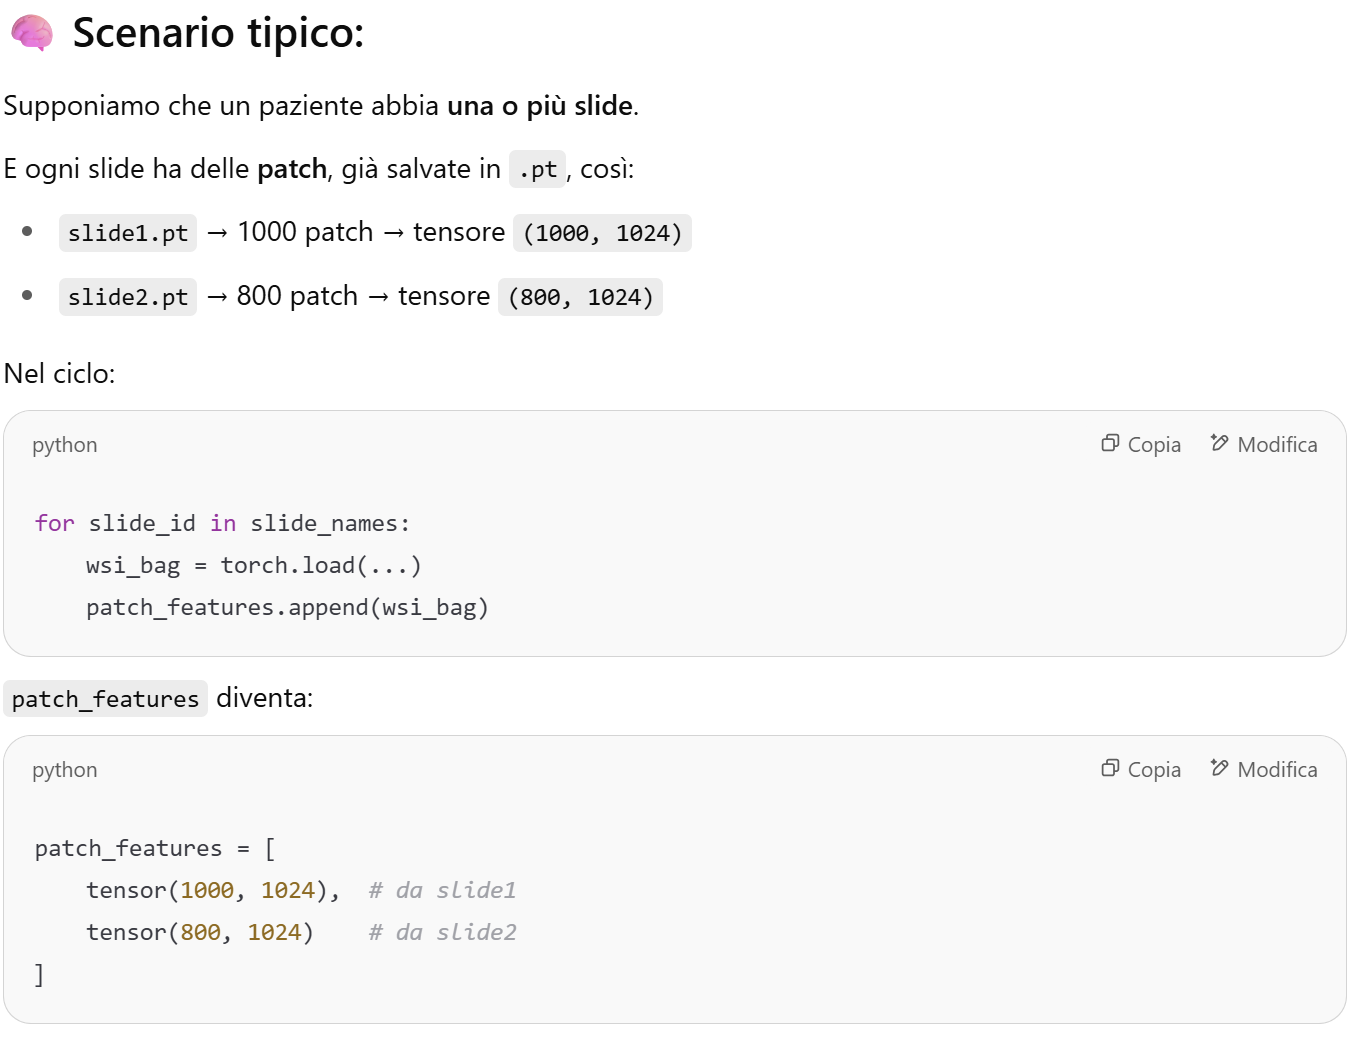

🎯 Perché concatenare patch di slide diverse per uno stesso paziente?
Risposta breve:
Perché il modello non distingue tra le slide, ma lavora con tutte le patch del paziente come se fossero un unico “bag of patches”.

È un approccio tipico nel Multiple Instance Learning (MIL) o nei modelli multimodali di deep learning per immagini mediche.

🧠 Ragionamento concettuale
Tu vuoi fare una previsione per il paziente, non per la singola slide.

Se un paziente ha una sola slide, prendi tutte le sue patch → tutto ok.

Se ne ha più di una, tutte le patch sono comunque immagini dello stesso paziente.

➡️ Quindi:

Ha senso ragionare a livello di paziente, non a livello di singola slide.

👨‍⚕️ Esempio clinico:
Un paziente ha due sezioni del tumore in due vetrini diversi (due slide_id), ma sono dello stesso tumore.

Quindi, nel modello:

Le patch delle due slide vengono unite

E trattate come “tutte le informazioni visive disponibili per quel paziente”

In [31]:
class Multimodal_WSI_Genomic_Dataset(Dataset): #Dataset è una classe base astratta che PyTorch fornisce per creare dataset personalizzati.
    #“Sto costruendo un dataset personalizzato che PyTorch può usare in un DataLoader, e implementerò i metodi necessari (__getitem__, __len__, ecc.)”
    def __init__(self,  datasets_configs = [TCGA_BRCA_dataset_config],
                        task_type="Survival", # Survival or treatment_response
                        max_patches=4096,
                        n_bins=4,
                        eps=1e-6,
                        sample=True, #Se ci sono troppe patch, ne seleziona a caso un sottoinsieme (sample = True)
                        #Se ce ne sono meno, fa padding (aggiunge righe di zeri)
                         #→ e costruisce una mask per distinguere le patch vere da quelle "finte"
                        load_slides_in_RAM=False, #Ad ogni accesso (__getitem__), i file .pt vengono letti da disco:
                        ):
        self.task_type = task_type
        self.load_slides_in_RAM = load_slides_in_RAM
        if self.load_slides_in_RAM:
            self.slides_cache = {}

        self.datasets = {} # Qui inizializziamo un dizionario vuoto per salvare le configurazioni dei dataset.
        for i, dataset_config in enumerate(datasets_configs):#Questo ci permette di aggiungere più dataset senza doverli passare direttamente nel costruttore.
            # config = yaml.load(open(dataset_config, "r"), yaml.FullLoader)
            # config = munchify(config)
            config = dataset_config
            if config.name in self.datasets:#assegniamo i parametri corretti del dataset pescato una sola volta
                raise ValueError("Dataset name {} already exists".format(config.name))
            self.datasets[config.name] = config.parameters # asser config.name in datasets  #qui devi capire che datasets è un dizionario che fino a poco fa era vuoto e quindi
            #stai dicendo che la prima chiave è config.name(quindi il nome del dataset di riferimento) e il valore sono i parametri dello stesso
            #questa sintassi è permessa dal fatto che abbiamo definito TCGA_BRCA_dataset_config che passa per config e poi all'interno del diz "datasets" creiamo
            #questa nuova associazione del tipo config.name ( nome del diz) --> e i relativi parametri

            dataframe = pd.read_csv(config.parameters.dataframe_path, sep="\t",dtype={'case_id': str}) #ricordati che sei in un ciclo for quindi config.name si riferisce al
            #diz di questa iterazione, quindi anche dataframe cambierà in base a quale config hai
            dataframe = dataframe.dropna()
            #dataframe["dataset_name"]--> creo una nuova colonna
            #Per ogni riga del dataframe, assegna lo stesso valore: config.name (es. "TCGA_BRCA")
            dataframe["dataset_name"] = [config.name for _ in range(len(dataframe))] #serve per identificare il dataset a cui stiamo facendo riferimento
            #utile per dataet multipli# nella riga sopra andiamo a creare una nuova colonna in cui avremo tutti i valori del dataset a cui stiamo facendo riferimento
            #andiamo a rinominare i nomi delle colonne in modo da standardizzare i nomi per tutti i possibili dataset che useremmo, così da avere
            #sempre gli stessi nomi
            if task_type == "Survival": #per adattare le colonne del dataframe a seconda del tipo di task (Survival o treatment_response).
                rename_dict = { self.datasets[config.name].label_name: "time",
                                self.datasets[config.name].censorships_name: "censorship",
                                self.datasets[config.name].case_id_name: "case_id",
                                self.datasets[config.name].slide_id_name: "slide_id"}
                dataframe.rename(columns=rename_dict, inplace=True)
                dataframe["time"] = dataframe["time"].astype(int)
                self.case_id_name = "case_id"
                self.slide_id_name = "slide_id"
            else:
                self.case_id_name = self.datasets[config.name].case_id_name
                self.slide_id_name = self.datasets[config.name].slide_id_name
            # dataframe = self.filter_by_tissue_type(config.name, dataframe, config.parameters.tissue_type_filter)

            # load genomics data
            genomics = pd.read_csv(config.parameters.genomics_path, sep="\t", dtype={'Unnamed: 0': str})#carichiamo i dati di espressione genica
            genomics = genomics.set_index("Unnamed: 0").dropna()#pulizia
            genomics = np.log(genomics+0.1)#normalizzazione logaritmica per diminuire l'ampiezza delle variazioni tra geni +
            #+0.1 che serve per evitare il logartimo di 0 che è indefinito

            if i==0: # Se i == 0, significa che stiamo caricando il primo dataset.
                self.dataframe = dataframe
                self.genomics = genomics
            else:#Se stiamo caricando più dataset, li concatenamo (pd.concat()) ignore_index=True serve per riallineare gli indici dopo la concatenazione.
                self.dataframe = pd.concat([self.dataframe, dataframe], ignore_index=True)
                self.genomics = pd.concat([self.genomics, genomics], ignore_index=True)

        #{'pAdnL', 'pOvaR', 'pMes1', 'pOth', 'pTubL', 'pPer', 'pAdnR', 'pTubL1', 'pOva', 'pTubR', 'p2Ome2', 'pPer2', 'pVag', 'pLNR', 'pUte1',
        # 'pPerR1', 'pOvaL1', 'pOvaL', 'p2Oth', 'pPer ', 'pTub', 'pOme2', 'p0Ome', 'pUte2', 'pOva2', 'pMes', 'pOme ', 'pBow', 'pOme1', 'pOth2',
        # 'pAdnR1', 'pOth1', 'p2Ome1', 'pOme', 'p2Per1', 'pPer3', 'pOvaR1', 'pPerL ', 'pUte', 'pOme3', 'pAndL', 'pTub2', 'pPer1'}
        # self.pt_files_path = pt_files_path
        self.max_patches = max_patches # Quante patch usare da ogni Whole Slide Image (WSI). Utile per controllare il carico computazionale o per campionamento.
        self.sample = sample #Se True, campiona le patch casualmente, invece di prendere tutte le patch disponibili.
        self.n_bins = n_bins #Numero di intervalli (bins) per la discretizzazione del tempo di sopravvivenza.
        # self.label_name = label_name
        # self.censorships_name = censorships_name
        self.eps = eps #Valore molto piccolo per evitare errori numerici nelle operazioni matematiche (es. logaritmi o divisioni).
        # self._filter_by_tissue_type()

        #Queste due funzioni a seguire servono a organizzare i pazienti e le loro informazioni.
        self._compute_patient_dict() # Creare un dizionario che associa ogni case_id (paziente) alla lista delle sue slide_id (immagini).
        self._compute_patient_df()# Tieni una sola riga per paziente nel caso ci fossero più slide_id.
        if self.task_type == "Survival":
            self._compute_labels()
        else:
            self.patient_df["label"] = self.patient_df["Treatment_Response"]
        print("Dataset loaded with {} slides and {} patients".format(len(self.dataframe), len(self.patient_df)))

    #Qui creiamo un dizionario in cui ogni paziente ha la sua lista di immagini (slide).
    #In teoria nel dataset abbiamo una corrsipoindenza uno a uno tra l'immagine e il paziente ma questo codice vuole generalizzare il caso in cui
    #avessimo più immagini per un paziente

    def _compute_patient_dict(self):
        self.patient_list = list(self.dataframe[self.case_id_name].unique())#Creiamo una lista di pazienti unici,  contiene tutti gli ID paziente senza duplicati. case_id_name sarebbe il paziente
        self.patient_dict = {patient: list(self.dataframe[self.dataframe[self.case_id_name] == patient][self.slide_id_name]) for patient in self.patient_list} #dizionario con le
        #immagini per ogni paziente
        #sopra abbiamo creato , per ogni paziente, una lista con tutte le immagini associate a lui.

    def _compute_patient_df(self):# Creiamo il DataFrame pulito
        # Qui prendiamo il dataframe e lo trasformiamo in un dataset in cui ogni paziente appare solo una volta.
        self.patient_df = self.dataframe.drop_duplicates(subset=self.case_id_name) #Se un paziente ha più di un record (perché ha più immagini), ne teniamo solo uno.
        self.patient_df = self.patient_df.reset_index(drop=True)#riordina l'indice
        self.patient_df = self.patient_df.set_index(self.case_id_name, drop=False) #Ora case_id è l’indice del DataFrame, quindi possiamo
        #cercare velocemente i dati di un paziente.

        #Il dizionario (self.patient_dict) serve per mappare ogni paziente alle sue immagini.
        #Il DataFrame (self.patient_df) serve per avere un dataset pulito con un solo record per paziente e per fare analisi.

    def get_train_test_val_splits(self, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42): #Obiettivo: Creare un dataset bilanciato, normalizzare i dati genomici e restituire le liste di pazienti nei tre gruppi.
        np.random.seed(random_state) #Imposta il seme per la riproducibilità
        patients = np.array(self.patient_list) # Converte la lista dei pazienti in un array NumPy
        # Qui creiamo una lista con tutti i pazienti e la mescoliamo casualmente.
        np.random.shuffle(patients)

        #Qui dividiamo i pazienti in tre gruppi in base alle proporzioni scelte.
        n = len(patients) # Numero totale di pazienti
        train_end = int(n * train_size)# Numero di pazienti per il training set
        val_end = int(n * (train_size + val_size)) # Numero di pazienti per training + validation
        train_patients = patients[:train_end] # Primi pazienti nel training set
        val_patients = patients[train_end:val_end] # Pazienti successivi nel validation set
        test_patients = patients[val_end:] # Ultimi pazienti nel test set

        train_patients_idx = pd.Index(train_patients)
        val_patients_idx = pd.Index(val_patients)
        test_patients_idx = pd.Index(test_patients)
        # for name in self.genomics.columns.tolist():
        #     scaler  = StandardScaler()
        #     self.genomics.loc[train_patients_idx, name] = scaler.fit_transform(self.genomics.loc[train_patients_idx, name].values.reshape(-1,1)).ravel()
        #     self.genomics.loc[val_patients_idx, name]   = scaler.transform(self.genomics.loc[val_patients_idx, name].values.reshape(-1,1)).ravel()
        #     self.genomics.loc[test_patients_idx, name]  = scaler.transform(self.genomics.loc[test_patients_idx, name].values.reshape(-1,1)).ravel()


        #I dati genomici possono avere valori con scale molto diverse
        #Dobbiamo ridimensionare tutti i valori in un range simile, altrimenti il modello potrebbe dare più importanza ai geni con numeri grandi.
        self.normalized_genomics = deepcopy(self.genomics) #Creiamo una copia dei dati genomici per non modificare quelli originali.
        X_train = self.normalized_genomics.loc[train_patients_idx, :]
        X_val = self.normalized_genomics.loc[val_patients_idx, :]
        X_test = self.normalized_genomics.loc[test_patients_idx, :]

        scaler = StandardScaler()
        scaler.fit(X_train)  # fit on train set

        # Transform entire subsets of the copied DataFrame
        self.normalized_genomics.loc[train_patients_idx, :] = scaler.transform(X_train)
        self.normalized_genomics.loc[val_patients_idx, :] = scaler.transform(X_val)
        self.normalized_genomics.loc[test_patients_idx, :] = scaler.transform(X_test)

        # train_indices = [i for i, patient in enumerate(self.patient_list) if patient in train_patients]
        # val_indices = [i for i, patient in enumerate(self.patient_list) if patient in val_patients]
        # test_indices = [i for i, patient in enumerate(self.patient_list) if patient in test_patients]
        print("Train: {}, Val: {}, Test: {}".format(len(train_patients), len(val_patients), len(test_patients)))
        assert len(train_patients) + len(val_patients) + len(test_patients) == len(self.patient_list) #	Controlla che tutto sia andato bene
        return train_patients, val_patients, test_patients #In modo che il resto del codice possa usarli per allenare e testare il modello.


    #la funzione qui sotto: per assegnare un'etichetta (label) di sopravvivenza a ciascun paziente,
    #dividendo i pazienti in fasce di tempo (bin) in base alla durata di sopravvivenza.

    #Hai un dataset con una colonna "time" che rappresenta i mesi di sopravvivenza di ciascun paziente.
    #L’obiettivo è trasformare questi numeri in classi (etichette) da dare al modello, es.:

    #Pazienti che vivono poco → classe 0
    #Pazienti che vivono tanto → classe 3
    #(dipende da quante classi scegli)

    #0 → evento osservato → non censurato ✅, cioè sappaimo data in cui l'evento inizia e data di morte ( es: ha vissuto 24 mesi)
    #1 → evento non osservato → censurato ❌

    #Quando calcoli le etichette di sopravvivenza, ha senso usare solo i pazienti non censurati (censorship == 0) perché sai quanto hanno vissuto davvero.

    #I censurati non puoi usarli per calcolare bin temporali precisi, perché il valore che hai potrebbe essere solo un minimo (il paziente potrebbe essere ancora vivo, ma non sai per quanto).
    def _compute_labels(self): #Obiettivo --> Trasformare i tempi di sopravvivenza (time) in classi discrete (label) da usare come etichette nel modello.
  #📌 Questo è utile quando vuoi formulare la sopravvivenza come problema di classificazione
  # (es. predire in quale intervallo temporale morirà il paziente).
        #Prende solo i pazienti non censurati (cioè quelli per cui sappiamo il tempo di sopravvivenza reale).
        #Divide i loro time in n_bins con lo stesso numero di pazienti (quasi).
      #Ritorna:
        #q_bins = lista dei confini temporali tra i gruppi.
        #disc_labels = etichetta assegnata a ciascun paziente (ma solo ai non censurati).
      #🎯 Obiettivo: trovare dei bin con una distribuzione bilanciata tra i pazienti. Quindi come puoi intuire per far entrare un numero di
      #pazienti più o meno uguale in tutti i bin bisogna avere dei bin non equidistanti tra loro

        uncensored_df = self.patient_df[self.patient_df["censorship"] == 0] #Usa solo i pazienti non censurati per calcolare le soglie di tempo.
        disc_labels, q_bins = pd.qcut(uncensored_df["time"], q=self.n_bins, retbins=True, labels=False, duplicates='drop') #pd.qcut() divide
        #la colonna time in quantili, cioè cerca di fare gruppi con lo stesso numero di pazienti.
        # retbins=True → restituisce anche i valori di soglia dei bin.
        # labels=False → restituisce numeri (0, 1, 2...) come etichette.  Chi ha vissuto poco → label 0   Se n_bins = 4

        # duplicates='drop' → evita crash se ci sono troppi valori uguali.
        #qcut ha calcolato questi bin solo usando i pazienti non censurati.
        #Quindi: quei bin potrebbero non includere i valori estremi dell'intero dataset, soprattutto i censurati. Per questo motivo facciamo max e min
        #quindi per calcolare massimo e minimo stiamo usando tutti i pazienti
        q_bins[-1] = self.patient_df["time"].max() + self.eps #→ l’ultimo valore del bin diventa il massimo tempo di tutti i pazienti + qualcosa di piccolo (eps) per includere l’estremo.
        q_bins[0] = self.patient_df["time"].min() - self.eps #→ il primo valore diventa il minimo - eps, per includere anche il minimo.

        # assign patients to different bins according to their months' quantiles (on all data)
        # cut will choose bins so that the values of bins are evenly spaced. Each bin may have different frequncies

        #qui sotto facciamo l'assegnazione finale delle etichette con cut

        #Prende tutti i pazienti (censurati e non).
        #Usa i bin calcolati prima (q_bins) per assegnare a ciascuno una label corrispondente al suo tempo di sopravvivenza.
      #🎯 Obiettivo: usare i bin calcolati in modo "intelligente" per assegnare un'etichetta anche ai censurati.

#usiamo prima qcut per creare classi bilanciate e poi visto che per farlo si usano solo i non censurati dobbiamo usare cut per dare
# una etichetta a tutti quanti ( anche quelli censurati )
        disc_labels, q_bins = pd.cut(self.patient_df["time"], bins=q_bins, retbins=True, labels=False, right=False, include_lowest=True) # il label = False ti permette di restituirti non i bin così come sono ma in termini di 0 = primo bin, 1 = secondo bin ecc
        self.patient_df.insert(2, 'label', disc_labels.values.astype(int))#Inserisce una nuova colonna label nella posizione 2 del DataFrame
        #Ogni paziente riceve il suo bin temporale come etichetta
        self.bins = q_bins # qui salviamo i bin per non perderli, cioè vogliamo sempre sapere eventualmente il primo bin che range copre realmente


#obiettivo di questa funzione: Caricare i file .pt che contengono le feature estratte dalle immagini istologiche (WSI) di un paziente (o meglio, di tutte le sue slide),
# metterle tutte insieme in un unico tensor PyTorch e, se serve, campionarle per limitarne il numero.
    def _load_wsi_embs_from_path(self, dataset_name, slide_names): #slide_names -->lista degli slide_id di un paziente (anche se spesso è solo uno)
            #questa funzione viene chiamata giù da patch_features, mask = self._load_wsi_embs_from_path(dataset_name, slide_list)
            #dove slide_list sono tutte le slide di un singolo paziente
            """
            Load all the patch embeddings from a list a slide IDs.

            Args:
                - self
                - slide_names : List

            Returns:
                - patch_features : torch.Tensor
                - mask : torch.Tensor

            """
            patch_features = [] #un tensore con tutte le patch visive, Inizializza lista per le feature, qui andrò a concatenerare tutte le feature
            #della patch di quella slide andando avanti nel modo in cui è mostrata l'immagine sopra
            pt_files_path = self.datasets[dataset_name].pt_files_path #Recupera il path dei file .pt dalle config relativo al dataset che ci interessa,
            #dal momento che possono esserci più dataset. Ricordati che abbiamo creato una colonna per identificare il dataset
            #Ogni slide ha il suo file .pt che contiene le feature visive pre-estratte (es. da un modello CNN tipo ResNet o Vision Transformer).
            # load all slide_names corresponding for the patient, Cicla su ogni slide del paziente

            #ricordati che il file .pt:
            #Se una slide è stata divisa in 1200 patch, e ogni patch è stata passata in una ResNet/Vision Transformer
            # che genera un vettore di 1024 feature, allora il .pt contiene: torch.Size([1200, 1024])

            for slide_id in slide_names:
                if self.load_slides_in_RAM: #Questo serve per non rileggere dallo storage ogni volta, ma tenere tutto in RAM (più veloce, ma serve memoria).
                    if slide_id in self.slides_cache:
                        wsi_bag = self.slides_cache[slide_id]
                    else:
                        wsi_path = os.path.join(pt_files_path, '{}.pt'.format(slide_id))
                        wsi_bag = torch.load(wsi_path, weights_only=True) #wsi_bag è un tensore che contiene le feature di tutte
                        #le patch di quella slide.
                        self.slides_cache[slide_id] = wsi_bag #qui dopo averla presa dal path la metto in cache
                else:
                    wsi_path = os.path.join(pt_files_path, '{}.pt'.format(slide_id))
                    wsi_bag = torch.load(wsi_path, weights_only=True) # changed to True due to python warning
                    #carichi le feature (wsi_bag) da .pt, che è un tensore di shape es. [num_patch_slide_i, embedding_dim]
                patch_features.append(wsi_bag) #Aggiunge le feature della slide a patch_features
            patch_features = torch.cat(patch_features, dim=0) # Concatena tutto in un solo tensore
            # print("patch_features.shape[0]: ", patch_features.shape[0])
            #❗ E qui succede la parte chiave MIL:

            #Concateni tutte le patch in un unico tensore,
            #che rappresenta il bag completo del paziente.
            #quindi se hai:
                #patch_features = [
                  #tensor(1000, 1024),
                  #tensor(600, 1024)
                    #]
            #dopo torch.cat --> patch_features = tensor(1600, 1024)

            if self.sample: #e self.sample=True, fai campionamento (per limitare il numero di patch)
                max_patches = self.max_patches

                n_samples = min(patch_features.shape[0], max_patches) #si limita il campionamento a max_patches
                #Se hai meno patch di max_patches, le tieni tutte
                #Se hai più patch, ne scegli max_patches a caso
                idx = np.sort(np.random.choice(patch_features.shape[0], n_samples, replace=False))
                patch_features = patch_features[idx, :]
                #Estrai n_samples righe (patch) a caso
                #Le ordini (opzionale)
                #E tieni solo quelle


                # make a mask--> una maschera che indica quali patch sono reali e quali sono padding (se serve)
                if n_samples == max_patches: #  Se hai esattamente max_patches allora: Niente padding, Tutte le patch sono reali → maschera tutta di 0
                    # sampled the max num patches, so keep all of them
                    mask = torch.zeros([max_patches]) #Qui stai indicando se una patch è reale o finta: 0 → patch reale ✅, 1 → patch finta (padding) ❌
                else:
                    # sampled fewer than max, so zero pad and add mask-->#Se campioni meno patch del massimo costruisco la maschera ( 0 patch reale, 1 patch fittizia(padding))
                    original = patch_features.shape[0] # numero di patch reali effettive (dopo campionamento)
                    how_many_to_add = max_patches - original # quante patch finte (padding) servono
                    zeros = torch.zeros([how_many_to_add, patch_features.shape[1]]) #Ogni riga è una patch con tutti zeri
                    #zeros = ... Qui stai creando dati finti, cioè patch di padding.
                    #Valori 0 → perché vogliamo che non contengano nessuna informazione.
                    #⚠️ Non significa che "sono reali", significa "sono vuote"
                    patch_features = torch.concat([patch_features, zeros], dim=0)
                    mask = torch.concat([torch.zeros([original]), torch.ones([how_many_to_add])])# Crea una maschera 1D che serve a distinguere:
                    #Le patch reali → 0, Le patch di padding → 1

            else:
                mask = torch.zeros([patch_features.shape[0]]) #Nessun campionamento, nessun padding → tutte patch reali.

            return patch_features, mask

    def set_sample(self, sample): #È un metodo setter che serve a modificare il valore di self.sample da fuori la classe, in modo controllato.
        self.sample = sample # True → campioni (limiti il numero di patch, es. max 4096)
                              # False → usi tutte le patch disponibili

    def __getitem__(self, index):
        # Retrieve data from the dataframe based on the index
        row  = self.patient_df.loc[index] # Prende la riga del DataFrame patient_df corrispondente all’indice index.
        #patient_df ha un solo record per paziente, quindi qui prendi il paziente index-esimo.

        genomics = torch.tensor(self.normalized_genomics.loc[index].values, dtype=torch.float32)#Prende i dati genomici
        # normalizzati per quel paziente, li converte in un tensor PyTorch.
        dataset_name = row["dataset_name"] # da quale dataset proviene questo paziente.
        tissue_type_filter = self.datasets[dataset_name].tissue_type_filter #se presente, specifica filtri sul tipo di tessuto (non sempre usato).
        slide_list = self.patient_dict[row[self.case_id_name]] #slide_list: prende tutte le slide_id associate al paziente, da patient_dict.
        patch_features, mask = self._load_wsi_embs_from_path(dataset_name, slide_list)#Carica le immagini istologiche (.pt) di
        # tutte le slide del paziente → concatena le patch → campiona se serve → crea una maschera per il padding.
        label = row['label'] #La label è quella calcolata prima: ad es. un bin (0–3) di sopravvivenza.

        #Se stai facendo Survival Analysis, servono anche:

        if self.task_type == "Survival":
            censorship = row["censorship"] ##censorship: se il paziente è censurato (1) o no (0)
            time = row["time"] #time: tempo di sopravvivenza in mesi
            label_names = ["time"] ##label_names: metti "time" come nome dell’etichetta
        else: #Se il task non è "Survival", questi campi non servono (ma li metti lo stesso per compatibilità).
            censorship = torch.tensor(0)
            time = torch.tensor(0)
            label_names = ["treatment_response"]

        #Questo è l'oggetto che verrà passato al modello di predizione deep learning, come input + target.
        #Predire la sopravvivenza (Survival Analysis)
        #Predire la risposta a un trattamento (Treatment Response)
        #Usando immagini istologiche (WSI) + genomica come input
        # per approfondire vai su one note verso la fine spiegato bene

        #🔹 Questo è il dizionario finale che viene passato al modello:
        #Input = immagini (patch), mask, dati genomici
        #Target = label, tempo, censura
        #Info extra = patient_id, dataset_name
        data = {
                'input':{
                            'patch_features': patch_features,
                            'mask': mask,
                            'genomics':genomics
                        },
                'label': label,
                'censorship': censorship,
                'original_event_time': time,
                'label_names': label_names,
                'patient_id': row[self.case_id_name],
                'dataset_name': dataset_name,
            }
        return data

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.patient_df)

### Multimodal ABMIL

🌟 Premessa: vogliamo "pesare" le patch
Nel modello che stai studiando, abbiamo tante patch (piccoli pezzi di immagine).

L’idea è: non tutte le patch sono ugualmente importanti.

Quindi vogliamo:

Capire cosa c’è nella patch → V

Capire quanto è importante quella patch → U

Calcolare un punteggio di attenzione per ciascuna patch

🔹 V = torch.tanh(self.attention_V(x))
👉 Cosa fa?
Prende la patch x (un vettore di inner_dim numeri)

La trasforma linearmente con attention_V

Poi la passa attraverso tanh, una funzione non lineare

🎯 Obiettivo: generare un vettore contenuto → una rappresentazione trasformata di cosa c’è nella patch

✨ Pensalo come: “cosa contiene questa patch?”

🔸 U = self.sigmoid(self.attention_U(x))
👉 Cosa fa?
Prende sempre la stessa patch x

La trasforma con un altro layer lineare (attention_U)

Poi passa tutto in sigmoid, che comprime i numeri tra 0 e 1

🎯 Obiettivo: generare un vettore filtro → che decide quanto far passare di ogni elemento di V

🔍 Pensalo come: “quanto è importante questa patch?”, ma in modo morbido: non tutto o niente, ma un po’, tanto, poco...

Poi fai V * U che è Una moltiplicazione elemento per elemento (detta element-wise): ogni numero di V viene modulato da quello corrispondente di U.

Esempio
V = [0.8, 0.1, -0.5]
U = [0.9, 0.2, 0.0]
allora
V * U = [0.72, 0.02, 0.0]
🧠 Vuol dire: "la terza informazione di questa patch è irrilevante, ignorala (0)", la prima invece è molto importante (0.72).

🧠 Metafora:
Immagina V come la voce della patch:

“Ciao, io sono una patch tumorale!”

E U è un volume:

“Ok, ti lascio parlare forte (0.9), poco (0.2) o ti silenzio (0.0)”

Quindi V * U è la voce finale che arriva all’orecchio del modello.



In [ ]:
class ABMIL_Multimodal(nn.Module):
    def __init__(self,
                     input_dim=1024,
                     genomics_input_dim = 19962,
                     inner_dim=64,
                     output_dim=4,
                     use_layernorm=False,
                     input_modalities = ["WSI", "Genomics"],
                     genomics_dropout = 0.5,
                     dropout=0.0,
                ):
        super(ABMIL_Multimodal,self).__init__()

        self.inner_proj = nn.Linear(input_dim,inner_dim)#Questa è una rete neurale lineare (chiamata anche "fully connected" o "dense layer").
        #input_dim: è la dimensione delle patch in input (es. 1024)
        #inner_dim: è la nuova dimensione nascosta che vogliamo (es. 64)
        self.output_dim = output_dim #Se stai classificando in 4 classi: output_dim = 4, Non è un layer, è solo una variabile che ti tieni da parte.
        self.device="cuda" if torch.cuda.is_available() else "cpu"
        self.input_modalities = input_modalities
        self.use_layernorm = use_layernorm #Questa è una flag (booleana) che ti dice se vuoi usare o no la Layer Normalization.
        self.dropout = nn.Dropout(dropout)#Dropout è una tecnica per evitare che il modello impari "a memoria" i dati → evita overfitting.
        #A ogni passaggio spegne a caso alcune unità del modello (con probabilità dropout)
        if self.use_layernorm:#Se hai attivato use_layernorm, allora costruisci il layer LayerNorm, che:
                              #Normalizza ogni input per migliorarne la stabilità
                              #Serve per rendere l’apprendimento più stabile e veloce.
            self.layernorm = nn.LayerNorm(inner_dim)
        #- Stai dicendo al modello:
        #“Ogni patch dell’immagine non è ugualmente importante. Voglio che tu impari **quanto** pesare ciascuna patch.”
        self.attention_V = nn.Linear(inner_dim, inner_dim)#Prendi un vettore e trasformalo linearmente in un altro della stessa dimensione."
                                                          #`Crea un layer lineare completo (con pesi + bias)
                                                          #Riceve un tensore con inner_dim elementi (es. 64)
                                                          #Restituisce ancora un tensore con inner_dim elementi (quindi 64 → 64)
        #V è usato come contenuto
        #U come filtro di pesi tra 0 e 1
        #V → è un vettore contenuto, libero di avere anche negativi
        #U → è un modulatore, che dice “quanto mi interessa questa parte di V”

        self.attention_U = nn.Linear(inner_dim, inner_dim)#`È un altro layer identico nella forma, ma con pesi indipendenti
                                                          #Serve a creare un’altra trasformazione diversa su input simili

        self.sigmoid = nn.Sigmoid()
        self.attention_weights = nn.Linear(inner_dim, 1)#riduce tutto a un **peso singolo**

        self.genomics_dropout = nn.Dropout(genomics_dropout)
        #Obiettivo: Prendere un vettore molto lungo (con l’espressione genica di ~20.000 geni), e trasformarlo in un vettore più compatto
        #e utile per la classificazione finale.
        self.fc_genomics = nn.Sequential(#Una piccola rete neurale per processare i dati genomici
                                            nn.Linear(genomics_input_dim, inner_dim),
                                            nn.ReLU(),
                                            nn.Linear(inner_dim, inner_dim),
                                        )

        # Output layer
        final_layer_input_dim = 0    #Inizializza una variabile che useremo per calcolare la dimensione dell’input che riceverà il layer finale.
        if "WSI" in input_modalities:#Se nel modello stiamo usando le immagini WSI (Whole Slide Images), allora sappiamo che ci sarà un vettore
                                     #(embedding) di dimensione inner_dim (di solito 64).
                                     #Quindi diciamo: “Ok, il layer finale riceverà anche questa parte in input → aggiungiamo 64”.
            final_layer_input_dim += inner_dim
        if "Genomics" in input_modalities:
            final_layer_input_dim += inner_dim

        self.output_layer = nn.Linear(final_layer_input_dim, output_dim)

    def forward(self, data): #data deriva da __getitem__ visto sopra, è un dizionario
        # Extract patch features
        if "WSI" in self.input_modalities:
            x = data['patch_features']  # x is a dictionary with key 'patch_features'
            #x: è un tensore di tutte le patch visive per quel paziente, Esempio forma: [num_patches, input_dim], es. [1000, 1024]
            mask = data['mask']#mask: è un tensore che indica se una patch è reale (0) o padding (1)
            x = x[~mask.bool()].unsqueeze(0)#mask.bool() trasforma i valori in booleani (True = padding), cioè il padding si mette con degli 1, quindi trasformando in booleano diventa True
                                            #~mask.bool() nega → tiene solo le patch vere, quindi tiene solo gli zeri che sono quindi "False" e quindi vere
                                            #unsqueeze(0) aggiunge una dimensione "batch" → output shape sarà [1, num_patches, patch_dim]
                                        #1 = ovvero un paziente alla volta ( sarebbe il batch)
                                        #num_patches: numero di patch (immagini) per quel paziente
                                        #inner_dim: dimensione del vettore che rappresenta ogni patch (es. 64)
                                        #ricorda che ho tante patch per ogni singolo paziente

            x = self.inner_proj(x)#Riduce o trasforma ogni patch da es. 1024 → 64 dimensioni (o qualunque sia inner_dim)
                                  #ricordati che prima avevamo detto: self.inner_proj = nn.Linear(input_dim,inner_dim)

            if self.use_layernorm: #Se richiesto, normalizza le patch (LayerNorm aiuta la stabilità durante il training)
                x = self.layernorm(x)

            # Apply attention mechanism
            V = torch.tanh(self.attention_V(x))  # Shape: (batch_size, num_patches, inner_dim)-->Shape: (1, num_patches, inner_dim)
            #self.attention_V(x)
            #↳ è un layer lineare: nn.Linear(inner_dim, inner_dim)
            #↳ quindi prende ogni patch (vettore di dimensione 64, per esempio) e lo trasforma in un nuovo vettore di stessa dimensione (64).
            #Poi passa il risultato alla funzione torch.tanh
            #↳ tanh è una funzione non lineare che comprime ogni valore tra -1 e +1
            #↳ aiuta a rendere la rete più flessibile, non solo combinazioni lineari

            #🧠 Che cos’è V?
            #È un tensore che rappresenta la versione trasformata delle patch,
            #cioè un modo “intelligente” per codificare cosa contengono le patch dal punto di vista informativo.

            #🔸 V è il contenuto informativo, "cosa c’è nella patch".

            U = self.sigmoid(self.attention_U(x))  # Shape: (batch_size, num_patches, inner_dim)
            #💡 Cosa succede qui?
            #self.attention_U(x)
            #↳ è un altro layer lineare indipendente, con stessi input/output (64 → 64)
            #↳ anche qui si trasforma ogni patch in un nuovo vettore di dimensione 64

            #Poi passa tutto a self.sigmoid
            #↳ sigmoid è una funzione non lineare che restituisce valori tra 0 e 1
            #↳ funziona come un "filtro": 0 → spegne, 1 → lascia passare, valori intermedi = pesa parzialmente

            #🧠 Che cos’è U?
            #È il gate, cioè un meccanismo che decide quanto del contenuto di ogni patch (quello in V) va fatto “passare”.

            #🔸 U è il modulatore, "quanto lasciar passare della patch". Perché l’obiettivo non è bloccare V ma usare U per modulare l'importanza del contenuto.

            # Compute attention scores
            attn_scores = self.attention_weights(V * U)  # Shape: (batch_size, num_patches, 1)-->Hai una moltiplicazione element-wise →
            # per ogni patch, moltiplichi V[i] * U[i]
            #attentio_weights era un linear (inner_dim, 1) quindi passandogli V*U che è (batch_size, num_patches, inner_dim)
            #pythorc automaticamente gestisce usando solo le ultime due dimensioni di (batch_size, num_patches, inner_dim)
            #lasciando batch_size così com'è e facendo poi (num_patches,inner_dim) * (inner_dim, 1) = (num_patches,1)
            #infatti attn_scores ha dimensione (batch_size, num_patches, 1)

            #Questo è un processo per stimare i pesi di attenzione, non per applicarli.

            attn_scores = torch.softmax(attn_scores, dim=1)  # Shape: (batch_size, num_patches, 1)-->per ogni paziente, la somma dei pesi delle patch = 1
            #quel 1 finale sarebbe il nostro output finale, cioè il punteggio di attenzione per ogni patch
#Quindi non c’è Q, K, V, ma c’è comunque un meccanismo che:
#elabora ogni patch
#stima quanto pesa (attenzione)
#fa una somma pesata
#È lo stesso spirito, ma più leggero 🪶

            # Weighted sum of patch features
            #ricordati che x = [1, num_patches, inner_dim]--> cioè: 1 paziente, 1000 patch, 64 feature ciascuna
            #ricordati che attn_scores= (1, num_patches, 1)-->un punteggio per ogni patch (calcolato con un Linear(64, 1) + softmax(dim=1))
            #facendo torch.sum(attn_scores *x,dim = 1 ) stai andando a precisare lungo quale dimensione sommi e per questo motivo si annulla
            #nella dimensione finale perchè collassa
            weighted_sum = torch.sum(attn_scores * x, dim=1)  # Shape: (batch_size, inner_dim)-->Ora hai ancora [1, num_patches, inner_dim], ma ogni patch è pesata!
            #ricordati che la regola dei tensori breadcasting dice che quando fai la somma ( in questo caso dim=1 ), qualle dimensione collassa; quindi il tensore
            #finale sarà [1,inner_dim]
            weighted_sum = self.dropout(weighted_sum)

            # Final WSI embedding
            wsi_embedding = weighted_sum  #--> visto che hai sommato tutte le patch della wsi di quel paziente, mettiamo il risultato in wsi_embedding

        if "Genomics" in self.input_modalities:
            genomics = data["genomics"]
            genomics = self.genomics_dropout(genomics)
            # Final Genomic embedding
            genomics_embedding = self.fc_genomics(genomics)

        if "WSI" in self.input_modalities and "Genomics" in self.input_modalities:
            x = torch.cat([wsi_embedding,genomics_embedding], dim=1)
        elif "WSI" in self.input_modalities:
            x = wsi_embedding
        elif "Genomics" in self.input_modalities:
            x = genomics_embedding

        output = self.output_layer(x)  # Shape: (batch_size, output_dim) -->Rappresenta l’output del modello per un singolo batch → ha forma (batch_size, n_bins).
        #dove batch size rappresenta un certo numero di pazienti e n_bins i bins di morte

        return output

### Survival Loss (SurvPath)

Questo blocco definisce una funzione di loss per un modello di sopravvivenza a tempo discreto, usata ad esempio per stimare quanto a lungo una persona sopravvive dopo una diagnosi, o in generale il tempo fino a un evento.

Il modello restituisce h, cioè i logit delle probabilità di morte in ciascun intervallo di tempo (hazards = sigmoid(h)).

In [33]:
class NLLSurvLoss(nn.Module):
    """
    The negative log-likelihood loss function for the discrete time to event model (Zadeh and Schmid, 2020).
    Code borrowed from https://github.com/mahmoodlab/Patch-GCN/blob/master/utils/utils.py
    Parameters
    ----------
    alpha: float
        TODO: document
    eps: float
        Numerical constant; lower bound to avoid taking logs of tiny numbers.
    reduction: str
        Do we sum or average the loss function over the batches. Must be one of ['mean', 'sum']
    """

    """
    Negative Log-Likelihood Loss per modelli di survival analysis in tempo discreto.

    Questa loss è basata sul lavoro di Zadeh e Schmid (2020), ed è progettata per predire
    la distribuzione della sopravvivenza in bin temporali discreti.

    Il modello predice le hazard function (probabilità di morte a ogni bin),
    e la loss misura la probabilità negativa (logaritmica) del percorso osservato.

    Parameters
    ----------
    alpha : float, default=0.0
        Peso tra censurati e non censurati.
        - alpha = 0.0 → considera entrambi
        - alpha = 1.0 → considera solo i non censurati (loss parziale)

    eps : float, default=1e-7
        Costante per stabilità numerica (evita log(0))

    reduction : str, default='sum'
        Come aggregare la loss sul batch:
        - 'sum': somma totale--> restituisce la somma delle loss su tutti i pazienti del batch
        - 'mean': media del batch--> restituisce la media delle loss

        sum = Se vuoi che ogni batch contribuisca proporzionalmente al numero di esempi
        mean = Se vuoi che ogni batch contribuisca allo stesso modo, indipendentemente dalla dimensione


    References
    ----------
    Zadeh, S.G. & Schmid, M. (2020).
    "Bias in Cross-Entropy-Based Training of Deep Survival Networks".
    IEEE Transactions on Pattern Analysis and Machine Intelligence.
    https://ieeexplore.ieee.org/document/9098975
    """

    def __init__(self, alpha=0.0, eps=1e-7, reduction='sum'): #con alpha=0.0 --> Usa tutti i pazienti (censurati e non censurati), 
        #1.0--> Usa solo i non censurati
        super().__init__()
        self.alpha = alpha
        self.eps = eps
        self.reduction = reduction

        if reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction mode: {reduction}. Use 'mean' or 'sum'.")
        self.reduction = reduction

    def __call__(self, h, y, t, c):
        """
        Parameters
        ----------
        h: (n_batches, n_classes) -->L’output del tuo modello prima di applicare la sigmoid, Ogni riga è un paziente, ogni colonna è un intervallo temporale (un bin)
            The neural network output discrete survival predictions such that hazards = sigmoid(h).
        y_c: (n_batches, 2) or (n_batches, 3) --> n quale bin è avvenuto l'evento o la censura
            The true time bin label (first column) and censorship indicator (second column).
        """


        """
        🧩 y: label vera per ciascun paziente
        È un vettore (batch_size, 1)

        Contiene, per ogni paziente, l’indice del bin in cui è avvenuto l’evento (se c=0) o la censura (se c=1)

        Ad esempio:

        y = 3 → l'evento o la censura è avvenuto nel bin 3

        h[i, :] → tutti i logit per il paziente i

        h[i, y[i]] → logit per il bin effettivo osservato per il paziente i

        🔁 Quindi come si usano insieme?
        Convertiamo h in hazards = sigmoid(h) → ora ogni hazards[i][t] è la probabilità che il paziente i muoia nel bin t.

        Poi usiamo y per dire:

        “Fammi vedere la probabilità prevista per il bin giusto (quello in cui è morto o censurato)”

        Questa viene confrontata con l’osservazione reale (usando log probabilità) → e usata per calcolare la loss.

        🧠 In pratica:
        Per ogni paziente:

        Cos’hai dal modello?	h[i, :] (logits) → hazards[i, :] (probabilità di morire in ciascun bin)
        Cos’hai dal dataset?	y[i] = 3 → evento/censura osservata nel bin 3
        Cosa confronti?	La probabilità di sopravvivere fino a bin 2 (S(t-1)) e morire a bin 3 (h(t))
        Come?	Con log(S(t-1)) + log(h(t)) → se non censurato; solo log(S(t)) se censurato

        ✅ Quindi:
        h[i]: previsione del modello per il paziente i → include tutti i bin

        y[i]: dove è avvenuto l’evento/censura per quel paziente--> ground truth

        c[i]: ti dice se y[i] è evento reale (morte) o solo censura

        """

        """
        Parameters
        ----------
        h : torch.Tensor of shape (batch_size, n_bins)
            Logits del modello (output grezzo prima della sigmoid).

        y : torch.Tensor of shape (batch_size, 1)
            Bin temporale in cui è avvenuto l’evento (o la censura).

        t : torch.Tensor or None
            Tempo assoluto (non usato in questa loss).

        c : torch.Tensor of shape (batch_size, 1)
            Vettore binario: 0 = non censurato, 1 = censurato

        Returns
        -------
        loss : torch.Tensor
            Valore scalare della loss aggregata sul batch
        """
        return nll_loss(h=h, y=y, c=c,
                        alpha=self.alpha,
                        eps=self.eps,
                        reduction=self.reduction)


# TODO: document better and clean up
def nll_loss(h, y, c, alpha=0.0, eps=1e-7, reduction='sum'):
    """
    The negative log-likelihood loss function for the discrete time to event model (Zadeh and Schmid, 2020).
    Code borrowed from https://github.com/mahmoodlab/Patch-GCN/blob/master/utils/utils.py
    Parameters
    ----------
    h: (n_batches, n_classes)
        The neural network output discrete survival predictions such that hazards = sigmoid(h).
    y: (n_batches, 1)
        The true time bin index label.
    c: (n_batches, 1)
        The censoring status indicator.
    alpha: float
        The weight on uncensored loss
    eps: float
        Numerical constant; lower bound to avoid taking logs of tiny numbers.
    reduction: str
        Do we sum or average the loss function over the batches. Must be one of ['mean', 'sum']
    References
    ----------
    Zadeh, S.G. and Schmid, M., 2020. Bias in cross-entropy-based training of deep survival networks. IEEE transactions on pattern analysis and machine intelligence.
    """
    # print("h shape", h.shape)

    # make sure these are ints
    #Questo assicura che y e c siano interi, perché tra poco useremo y per fare indexing con torch.gather(), e PyTorch richiede indici interi.
    y = y.type(torch.int64)
    c = c.type(torch.int64)

    hazards = torch.sigmoid(h) #Ora hazards[t] = probabilità di morire nel bin t → come abbiamo detto: ( ricordati che h sono i logit)
    # print("hazards shape", hazards.shape)

    S = torch.cumprod(1 - hazards, dim=1) #Questo è il calcolo classico della survival function discreta:
    #La probabilità di sopravvivere fino al tempo t è il prodotto delle probabilità di non morire a ogni tempo precedente.
    #sarebbe la roba cumulativa-->S[t] = probabilità di sopravvivere fino al bin t,
    #S[i][t] = probabilità che il paziente i sia sopravvissuto fino al tempo t
    #hazards.shape = (batch_size, n_bins)
    #S.shape = (batch_size, n_bins)
    # print("S.shape", S.shape, S)--> S è un matrice dove batch_size sono i paziente e n_bins sono i bin
    #S[t] è la probabilità che un paziente sia sopravvissuto fino al tempo t
    #Ma... quando calcoliamo la likelihood, abbiamo bisogno di accedere a S[t-1], non S[t].
    #P(event at t) = S(t-1) * h(t)
    #S(t-1) è la probabilità di essere vivo fino a t-1
    #h(t) è la probabilità condizionata di morire proprio in t
    #shape di c è [batch_size, 1]
    S_padded = torch.cat([torch.ones_like(c), S], 1) #-->Vogliamo accedere a S(t-1) quando y = t, quindi spostiamo tutto di uno e mettiamo:
                                                       #S_padded[0] = 1.0 (vivi al tempo -1 per definizione)
    # S(-1) = 0, all patients are alive from (-inf, 0) by definition
    # after padding, S(0) = S[1], S(1) = S[2], etc, h(0) = h[0]
    # hazards[y] = hazards(1)
    # S[1] = S(1)
    #[torch.ones_like(c), S]-->Crea un tensore di tutti 1.0, della stessa forma di c,c ha forma (batch_size, 1) → quindi anche torch.ones_like(c) ha forma (batch_size, 1)
    #Cosa fa [torch.ones_like(c), S]-->Costruisce una lista di due tensori: Uno con 1.0 (per ogni paziente), L’altro è S
    #E cosa fa torch.cat(..., 1)?-->Concatena questi due tensori lungo la dimensione 1 (cioè le colonne).
    # Quindi aggiunge 1.0 come prima colonna di S.


    #torch.ones_like È un tensore di 1.0, con forma (batch_size, 1), Per ogni paziente, crea un 1 iniziale (cioè S(-1) = 1.0)

    #QUANDO PERò ABBIAMO CENSURATO QUINDI c=0:
    #Non sappiamo quando morirà, sappiamo solo che è sopravvissuto fino a un certo bin y. 
    # ⚠️ NOTA: Qui usiamo S(y) e NON h(y), perché non c’è morte osservata, quindi il modello non deve "indovinare quando" morirà.
    #Deve solo prevedere correttamente che sia ancora vivo fino lì.

    #🔢 Esempio concreto
    #Supponiamo:

    #y = 2 → il paziente è stato censurato tra 2 e 3 anni

    #c = 1 → censurato

    #S = [[0.9, 0.8, 0.6, 0.4]]

    #Allora:

    #S[y] = S[2] = 0.6
    #Il paziente è arrivato vivo fino al bin 2, quindi la loss sarà:

    #loss = -log(S(y)) = -log(0.6)


    # TODO: document and check

    # print("S_padded.shape", S_padded.shape, S_padded)


    #gather prende dei valori da un tenosore di input ( che ad esempio per s_prev è S_padded, lungo la dim=1, quindi voglio andare a pescare
    #tra le colonne e quindi i bin temporali). In questo caso vogliamo, per ogni paziente (righe), andare a prendere la colonna che corrisponde al bin y.
    #Ma siccome S_padded è costruito così:
        #colonna 0 = S(-1) = 1.0
        #colonna 1 = S(0)
        #colonna 2 = S(1)
        #colonna 3 = S(2)
    #Se y = 2, allora S_padded[y] = S(t-1) = S(1)

    # TODO: document/better naming
    surv_before_event = torch.gather(S_padded, dim=1, index=y).clamp(min=eps)#S(t-1) → Probabilità di essere vivo prima del bin di evento
    #prende i dati da Da S_padded (include S(-1)=1)
    hazard_at_event = torch.gather(hazards, dim=1, index=y).clamp(min=eps)#h(t) → Hazard, probabilità di morire nel bin t
    #prende i dati Da hazards = sigmoid(h)
    surv_at_bin_end = torch.gather(S_padded, dim=1, index=y+1).clamp(min=eps)#	S(t) → Probabilità di essere vivo fino alla fine del bin t
    #prende i dati Da S_padded
    # print('s_prev.s_prev', s_prev.shape, s_prev)
    # print('h_this.shape', h_this.shape, h_this)
    # print('s_this.shape', s_this.shape, s_this)

    # c = 1 means censored. Weight 0 in this case
    #Hai un modello di sopravvivenza discreto che vuole imparare:
    #Quando un paziente muore (non censurato), il modello deve:
    #Prevedere che era vivo prima
    #Prevedere che è morto in quel bin

    uncensored_loss = -(1 - c) * (torch.log(surv_before_event) + torch.log(hazard_at_event))# in questo caso il modello deve:
    #1) Prevedere che il paziente era vivo fino a prima
    #2) E che è morto proprio in quel bin
    censored_loss = - c * torch.log(surv_at_bin_end) #Il paziente è vivo fino alla fine del bin t, ma non sappiamo cosa succede dopo. 
    #Il modello deve solo azzeccare la sopravvivenza.


    # print('uncensored_loss.shape', uncensored_loss.shape)
    # print('censored_loss.shape', censored_loss.shape)

    neg_l = censored_loss + uncensored_loss#Somma delle due loss per ogni paziente. Ma possiamo ponderare con aplha
    #Se alpha = 0.0 → usi entrambi i tipi di loss
    #Se alpha = 1.0 → usi solo la parte non censurata
    if alpha is not None:
        loss = (1 - alpha) * neg_l + alpha * uncensored_loss

    #Hai un valore di loss per ogni paziente. Ora lo:
    #1)Sommi → sum → utile per tenere il totale
    #2)Medii → mean → utile per confronti tra batch
    if reduction == 'mean':
        loss = loss.mean()
    elif reduction == 'sum':
        loss = loss.sum()
    else:
        raise ValueError("Bad input for reduction: {}".format(reduction))

    return loss

### Select the model and define the hyperparameters

In [34]:
# Models
# device = "cpu"
device = "cuda"

models = {
    'ABMIL_Multimodal': ABMIL_Multimodal, #definizione e configurazione dei modelli
}
model_configs = {  #Ogni modello ha un suo dizionario di parametri che in questo caso sono gli iperparametri del modello
    'ABMIL_Multimodal': {
         "input_dim":1024,
         "genomics_input_dim" : 19962,
         "inner_dim":64,
         "output_dim":4,
         "use_layernorm":False,
         "input_modalities" : ["WSI", "Genomics"], # ["WSI", "Genomics"] # ["WSI"] # ["Genomics"]
         "genomics_dropout": 0.5,
         "dropout":0.0,
    },
}

# Istantiate Model
selected_model = "ABMIL_Multimodal"
net = models[selected_model](**model_configs[selected_model]) #** è lo unpacking dei parametri in Python: 
#Prende ogni coppia chiave: valore dal dizionario e la passa come se fosse scritta a mano:
#ABMIL_Multimodal(input_dim=1024, genomics_input_dim=19962, ...)
net = net.to(device)

# Loss
reduction = "mean" # sum or mean
loss_function = NLLSurvLoss(alpha=0.0, eps=1e-7, reduction=reduction) #qui stai assegnando l'oggetto NLLSurvLoss con i suoi parametri a una variabile
#chiamata "loss_function", quindi dal momento che in NLLSurvLoss è presente il metodo __call__ che accetta anche altri parametri te potrai fare
#una chiamata del tipo loss_function(h, y, t, c) in cui stai chiamando comunque l'oggetto NLLSurvLoss ma dal momento che dentro c'è il metodo __call__
#viene trattato come una funzione quindi loss_function(h, y, t, c) fa partire def __call__(self, h, y, t, c).
#la chiamata a __call__ esegue la vera loss tra predizione e GT

# Training Parameters
MACHINE_BATCH_SIZE = 1 #  quanti pazienti riesci a elaborare per volta sulla tua GPU/CPU. (Quanti pazienti puoi caricare realmente in RAM/GPU per step (es. 1))
TARGET_BATCH_SIZE = 8 #batch "effettivo" desiderato per la stabilità dell'ottimizzazione.(Quanto vorresti che fosse il batch effettivo (es. 8))
NUM_ACCUMULATION_STEPS = TARGET_BATCH_SIZE//MACHINE_BATCH_SIZE #significa che accumuli il gradiente per 8 batch piccoli prima di fare un passo dell'ottimizzatore (simuli un batch più grande).
#	Quanti step da 1 paziente devi fare prima di aggiornare i pesi (es. 8)

EPOCHS = 10
PATIENCE = 7
DEBUG_BATCHES = 4

# Optimizer
LR = 0.001 #Learning Rate: quanto velocemente il modello aggiorna i pesi
WEIGHT_DECAY = 0.0001 #Regolarizzazione L2 → evita overfitting penalizzando pesi grandi
optimizer = optim.RAdam( #È una variante di Adam, ma più stabile all'inizio del training (R sta per "Rectified"). meno oscillazioni iniziali.
                          net.parameters(),
                          lr=LR,
                          weight_decay=WEIGHT_DECAY,
            )
# Scheduler
scheduler_parameters = {
  "milestones": [], #qui puoi provare a mettere qualcosa, se ad esempio metti 10 vuol dire che all'epoca 10 avrei moltiplicato il learning rate 
  #per gamma (0.1) in modo da ridurre il learning rate e quindi rallentare il training
  "gamma": 0.1 #Fattore di riduzione → ogni volta che colpisci una milestone, moltiplichi lr per 0.1
}
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, **scheduler_parameters)

#L’ottimizzatore aggiorna i pesi del modello ad ogni batch.
#Il scheduler cambia la velocità (learning rate) con cui aggiorni, per adattarsi al progresso del training.
#Ad esempio se milestone = 10 Viene ridotta di 10 volte (×0.1) a ogni milestone: epoca 10, 20 e 30
#Serve per rallentare il learning man mano che il modello si avvicina a una buona soluzione

# Dataset Creation

🧠 Cosa stiamo facendo in generale?
Nel deep learning non possiamo caricare tutti i dati in RAM in una volta sola (troppo pesanti). Allora si usano i DataLoader che:

Prendono i dati a blocchi (batch).

Possono mischiarli (per il training).

Possono usarli in parallelo (più CPU → più veloce).

Passano i dati già pronti alla rete neurale.

🔍 Cosa fa questa funzione get_dataloaders(...)?
Serve per costruire 3 gruppi di pazienti:

train_patients: per insegnare al modello.

val_patients: per controllare come sta andando durante l’allenamento.

test_patients: per misurare le prestazioni finali.

🚂 Il viaggio dei dati dal Dataset al Modello
1. Hai un dataset (grande)
Immagina di avere 10.000 pazienti salvati nel tuo Dataset, ognuno con immagini e dati genomici.

2. Serve un dataloader: il treno dei dati
Il DataLoader crea dei “treni” di dati:

Ogni vagone è un batch (es. 8 pazienti).

Ogni volta che la rete ha finito un batch, dice: “prossimo batch, prego!”.

3. Come carichiamo i batch?
🔸 Caso base – num_workers = 0 (solo 1 persona carica a mano)
Il DataLoader aspetta che il modello chieda il batch.

Poi apre il file, legge i dati, li prepara (es. normalizza), e li manda al modello.

Ogni volta deve aspettare.

👉 È come avere 1 persona che cucina una pizza solo dopo che gliel'hai ordinata.

🔸 Caso avanzato – num_workers = 4 (4 persone che cucinano in parallelo)
Prima ancora che il modello chieda, 4 cuochi stanno già preparando le pizze (i batch).

Appena il modello finisce di mangiare, un altro batch è già pronto.

👉 Questo è il prefetch: preparare in anticipo i dati prima che servano.

4. Prefetch factor: quanti piatti prepara ogni cuoco?
prefetch_factor = 4 = ogni cuoco prepara 4 pizze in anticipo.

Quindi hai 16 batch pronti nel forno, pronti da servire 🔥.


🚚 Come funziona davvero?
Il DataLoader prende un batch (es. 8 pazienti) dal disco.

Lo carica in RAM.

Lo passa alla GPU o CPU (dove sta il modello).

Quando il modello ha finito, il DataLoader carica il prossimo batch in RAM.

In [35]:
def get_dataloaders(dataset, train_patients, val_patients, test_patients, data_loader_config):
    #dataset.patient_df.index è la lista dei pazienti presenti realmente nel dataset. creato all’interno
    #  della classe Multimodal_WSI_Genomic_Dataset
    #train_patients è una lista (o array) con ID dei pazienti che vuoi usare per il training.
    #np.isin(...) crea un array booleano che dice “questo paziente è davvero presente?”
    mask = np.isin(train_patients, dataset.patient_df.index) #Controlla se alcuni ID in train_patients non esistono realmente nel dataset
    #(dopo il filtro con .isin()).
    # Filter the array to keep only elements in df.index
    filtered_train_patients = train_patients[mask]
    if len(filtered_train_patients) != len(train_patients):
        print("Some train patients are not in the dataset: ", set(train_patients) - set(filtered_train_patients))
    prefetch_factor = 4 #prefetch_factor serve per dire quanti batch il DataLoader può “precaricare” in anticipo in background. 
    #Qui stiamo dicendo 4 batch
    if data_loader_config.num_workers == 0: #Se non usi worker multipli (num_workers = 0), non ha senso precaricare → lo disabilita con None
        prefetch_factor = None
    train_dataloader = DataLoader( #Creare un DataLoader per il training, che carica dati dal dataset solo per i pazienti 
                                    #di training (filtered_train_patients) e li prepara a blocchi per il modello.

                                Subset(dataset, filtered_train_patients), #Qui crei un sottoinsieme del dataset contenente solo i pazienti 
                                #di training.
                                #filtered_train_patients è una lista di indici (ID pazienti presenti sia nel file che nel dataset).
                                batch_size=data_loader_config.batch_size, #Quanti pazienti vengono caricati contemporaneamente nella RAM. Esempio: se è 8, significa 8 pazienti per batch.
                                shuffle=True, #Mescola i dati ad ogni epoca (fondamentale per il training).
                                drop_last=True, #Se l’ultimo batch ha meno di batch_size pazienti, lo scarta. Serve a mantenere batch sempre uguali per compatibilità (es. batch norm).
                                pin_memory=True, #Copia più velocemente i dati dalla RAM alla GPU.
                                num_workers=data_loader_config.num_workers, #Quanti processi paralleli usi per caricare i dati.
                                prefetch_factor=prefetch_factor #Quanti batch caricare in anticipo per ogni worker. 
                            )
    if val_patients is not None: # Se hai specificato dei pazienti per il validation set, allora procedi.
        mask = np.isin(val_patients, dataset.patient_df.index) #Tiene solo i pazienti che esistono davvero nel dataset (serve a evitare errori).
        filtered_val_patients = val_patients[mask]
        if len(filtered_val_patients) != len(val_patients):
            print("Some val patients are not in the dataset: ", set(val_patients) - set(filtered_val_patients))
        batch_size = data_loader_config.batch_size
        if data_loader_config.test_sample == False: # Se sei in fase di test (no sampling), il batch size diventa 1.
            #Questo serve per processare un paziente alla volta, utile in validazione per evitare mescolamenti e per metriche individuali.
            batch_size = 1 #Perché in certi esperimenti, la validazione viene fatta paziente per paziente (come nel test) per calcolare metriche individuali.
        val_dataloader = DataLoader( #che contiene i dati di validazion set
                                        Subset(dataset, filtered_val_patients),
                                        batch_size=batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        pin_memory=True,
                                        num_workers=data_loader_config.num_workers,
                                        prefetch_factor=prefetch_factor,
                                )
    else:
        val_dataloader = None #Se non hai un validation set, restituisce None.
    if test_patients is not None:
        mask = np.isin(test_patients, dataset.patient_df.index)
        filtered_test_patients = test_patients[mask]
        if len(filtered_test_patients) != len(test_patients):
            print("Some test patients are not in the dataset: ", set(test_patients) - set(filtered_test_patients))
        batch_size = data_loader_config.batch_size
        if data_loader_config.test_sample == False:
            batch_size = 1
        test_dataloader = DataLoader(
                                        Subset(dataset, filtered_test_patients),
                                        batch_size=batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        pin_memory=True,
                                        num_workers=data_loader_config.num_workers,
                                        prefetch_factor=prefetch_factor,
                                    )
    else:
        test_dataloader = None
    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
data_loader_config = {
  "datasets_configs": [TCGA_BRCA_dataset_config],
  "task_type": "Survival",
  "max_patches": 4096, 
  "batch_size": MACHINE_BATCH_SIZE,
  "real_batch_size": TARGET_BATCH_SIZE,
  "n_bins": 4,
  "sample": True,        # sample patches during train
  "test_sample": False,   # use all available patches during testing
  "load_slides_in_RAM": True,  # load in RAM patches for increasing data loading speed
  "label_name": "FUT",
  "censorships_name": "Survival",
  "eps": 0.000001,
  "num_workers": 1,
  "train_size": 0.7,
  "val_size": 0.15,
  "test_size": 0.15,
  "random_state": 42,
}

data_loader_config = Munch.fromDict(data_loader_config)

In [37]:
dataset = Multimodal_WSI_Genomic_Dataset(
                        datasets_configs=data_loader_config.datasets_configs,
                        task_type=data_loader_config.task_type,
                        max_patches=data_loader_config.max_patches,
                        n_bins=data_loader_config.n_bins,
                        eps=data_loader_config.eps,
                        sample=data_loader_config.sample,
                        load_slides_in_RAM=data_loader_config.load_slides_in_RAM,
                    )

Dataset loaded with 1058 slides and 1058 patients


In [38]:
#qui vengono definiti i dati di training, validazione e test, e poi passati ai rispettivi DataLoader
#Divide gli ID dei pazienti in tre gruppi:
#È solo una divisione logica, cioè restituisce 3 liste di ID pazienti.
#Parametri:

#train_size, val_size, test_size: percentuali o numeri assoluti per definire le dimensioni dei set.
#random_state: seme per la riproducibilità → garantisce sempre la stessa divisione se ri-esegui il codice.



# GET INDICES FOR TRAIN, VALIDATION, AND TEST SETS
train_patients, val_patients, test_patients = dataset.get_train_test_val_splits(
                                                                                train_size=data_loader_config.train_size,
                                                                                val_size=data_loader_config.val_size,
                                                                                test_size=data_loader_config.test_size,
                                                                                random_state=data_loader_config.random_state
                                                                            )

#Prende le liste di pazienti e il dataset.
#Per ogni set (train/val/test), costruisce un DataLoader → che sarà usato per passare i dati al modello.
# Questo è proprio il punto in cui la tua rete inizia a ricevere batch di dati dal dataset, grazie a PyTorch DataLoader.
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
                                                                    dataset=dataset,
                                                                    train_patients=train_patients,
                                                                    val_patients=val_patients,
                                                                    test_patients=test_patients,
                                                                    data_loader_config=data_loader_config
                                                                    )

Train: 740, Val: 159, Test: 159


### Utility

In [39]:
def __reload_net__(path, device='cuda'):  #path: è il percorso del file .pt o .pth che contiene i pesi salvati del modello.
    if device == 'cuda': #device: specifica se vuoi caricare i pesi sulla GPU (cuda) o sulla CPU.
        print(f'\nRestoring model weigths from: {path}')
        return torch.load(path) #torch.load(path) carica direttamente i pesi sul dispositivo di default (in questo caso GPU, se disponibile).
    else: #Se stai lavorando su CPU, aggiunge map_location=torch.device('cpu') per forzare il caricamento dei pesi sulla CPU, anche se erano stati salvati da una GPU.
        print(f'\nRestoring model weigths from: {path}')
        return torch.load(path, map_location=torch.device('cpu'))

ella funzione nll_loss facciamo qualcosa di molto simile – calcoliamo i hazards e la curva di sopravvivenza (S), proprio come in calculate_risk.

In nll_loss:
hazards = torch.sigmoid(h)
S = torch.cumprod(1 - hazards, dim=1)

In calculate_risk:
hazards = torch.sigmoid(h)
survival = torch.cumprod(1 - hazards, dim=1)

Quindi in entrambi i casi:
Partiamo dai logits (h)
Applichiamo sigmoid per ottenere le hazard probabilities
Calcoliamo la curva cumulativa di sopravvivenza

La differenza è nel contesto d'uso:
nll_loss --> ha come scopo: Calcolare la loss per training--> Output: loss (scalar)
calculate_risk --> ha come scopo: Calcolare la rischiosità e S(t) --> Output: risk, survival (2 array)

nll_loss è usata durante l’addestramento, per aggiornare i pesi
calculate_risk è usata dopo, per stimare il rischio complessivo e creare metriche.

Pensa a calculate_risk come a una funzione di diagnostica sul modello, mentre nll_loss è la funzione di apprendimento.

In [40]:
#Questa funzione ( calculate_risk) trasforma i logits del modello (h) in un punteggio di rischio e in una curva di sopravvivenza discreta, per ogni paziente.
def calculate_risk(h):
    r"""
    Take the logits of the model and calculate the risk for the patient

    Args:
        - h : torch.Tensor

    Returns:
        - risk : torch.Tensor

    """
    hazards = torch.sigmoid(h) #Applichi la sigmoid sui logits h per ottenere probabilità tra 0 e 1
    survival = torch.cumprod(1 - hazards, dim=1) #Costruisci la sequenza cumulativa di sopravvivenza, È la probabilità che il paziente
    #sopravviva fino al bin t
    risk = -torch.sum(survival, dim=1).detach().cpu().numpy() #Ottieni un punteggio di rischio sommando tutta la curva di sopravvivenza 
    #(e cambiando segno):
    #più alta la somma => tendenza a sopravvivere => rischio basso (valore più negativo)
    #più bassa => sopravvivenza breve => rischio alto
    return risk, survival.detach().cpu().numpy() #Converti tutto in array NumPy e restituisci entrambi.

def initialize_metrics_dict(task_type="Survival"):
    #Obiettivo: Creare un contenitore vuoto dove salvare tutte le metriche (per tipo di task).
    #Dove viene usata: All’inizio di una fase di training, validazione o test — dentro la funzione step() o all’inizio dei loop di train()/evaluate().
    log_dict = {}
    if task_type == "Survival": #Esempio: per Survival salva rischi, tempi evento, censura, ecc. Serve per poi fare il calcolo delle metriche.
        log_dict["all_risk_scores"] = []
        log_dict["all_censorships"] = []
        log_dict["all_event_times"] = []
        log_dict["all_original_event_times"] = []
        log_dict["survival_predictions"] = []
    elif task_type == "Treatment_Response":
        log_dict["all_labels"] = []
        log_dict["treatment_response_predictions"] = []
        log_dict["treatment_response_logits"] = []
    else:
        raise Exception(f"{task_type} is not supported!")
    log_dict["patient_ids"] = []
    log_dict["dataset_name"] = []
    return log_dict

def compute_metrics_dict(log_dict): 
    #Obiettivo: Dato un log_dict (con i dati salvati durante l'inferenza), calcola il C-Index, una metrica classica della survival analysis.
    #Il C-index misura quanto bene il modello ordina i pazienti in base al rischio.
    #Quindi confronta le predizioni del modello con la ground_truth e li confronta tramite C-index
    #🧠 Cos’è il C-Index?
    #Il Concordance Index verifica:

    #“Il paziente che è morto prima ha un rischio predetto più alto?”

    #Se la risposta è sì per molte coppie → buon modello!
    #Il C-Index varia da 0.5 (casuale) a 1.0 (perfetto).

    # Dove viene usata: Principalmente per logging rapido: bastano rischi, censorship e event_times.
    # Cosa fa:
    #Estrae dai rispettivi elenchi i vettori numpy.
    #Calcola il C-index (metrica di ordinazione del rischio).
    #Ritorna un dizionario semplice: {"c-index": valore}.


    metrics_dict = {} #Inizializza un dizionario dove salveremo le metriche calcolate.

    #poi Recupera dal log_dict (che contiene i dati raccolti durante il test):
    all_risk_scores = np.array(log_dict["all_risk_scores"]) #i punteggi di rischio previsti per ogni paziente.
    all_censorships = np.array(log_dict["all_censorships"]) #1 = censurato, 0 = non censurato.
    all_event_times = np.array(log_dict["all_event_times"]) # in che bin è successo l’evento (morte, censura...).
    c_index = concordance_index_censored((1-all_censorships).astype(bool), all_event_times, all_risk_scores, tied_tol=1e-08)[0]
    #la funzione concordance_index_censored deriva da una libreria:
    #1 - all_censorships: trasforma: 1 (censurato) → 0 (non evento osservato) e 0 (non censurato) → 1 (evento osservato)
    #Così ottieni il booleano “evento osservato”.
    #Si calcola il C-Index: Confronta tutte le coppie di pazienti.
    #Considera solo quelle non censurate (cioè dove si sa chi è morto prima).
    #Verifica se il rischio predetto è coerente con l’ordine reale.
    #[0]: estrae solo il valore del C-Index (gli altri valori sono diagnostici).
    metrics_dict["c-index"] = c_index
    #quind il c index fa bene il suo lavoro se predice un rischio di morire alto per un paziente che dovrebbe morire prima
    #Il C-Index (concordance index) è fatto proprio per valutare quanto bene un modello:
    #Ordina i pazienti in base al rischio predetto
    # In modo che chi muore prima abbia un rischio più alto

    #Se il modello assegna un rischio maggiore a chi morirà prima (o ha avuto l’evento prima), allora:
    #👉 È concordante con la realtà
    #👉 Il C-Index si avvicina a 1.0 (perfetto)
    #Il C-Index non misura quanto sei preciso nel tempo esatto della morte, ma quanto sei bravo a capire chi morirà prima rispetto agli altri.
    return metrics_dict

def compute_metrics(log_df, task_type="Survival", device="cuda"): 
    #Obiettivo: Calcolare le metriche di valutazione in base al tipo di task:
    #Dove viene usata: Viene chiamata alla fine di un blocco, passando log_df, ovvero un DataFrame costruito da log_dict.
    #📋 Cosa fa:
    #Estrae array: all_risk_scores, censorships, event_times, outputs, ecc.
    #Ricalcola C-index usando la funzione da compute_metrics_dict.
    #Ricalcola la loss chiamando loss_function(...), passando:
    #outputs (logits),
    #event_times,
    #censorships.
    #Ritorna un dizionario con {"c-index": valore, "Loss": valore} (o le metriche di classificazione, se il task è Treatment_Response).

    if task_type == "Survival":
        #Qui si estraggono i dati salvati durante l’inferenza:
        all_risk_scores = log_df["all_risk_scores"].values
        all_censorships = log_df["all_censorships"].values
        all_event_times = log_df["all_event_times"].values #tempo (bin) in cui è avvenuto l’evento
        outputs = log_df["survival_predictions"].values #outputs: la curva di sopravvivenza predetta (i binari da sigmoid(h))
        c_index = concordance_index_censored((1-all_censorships).astype(bool), all_event_times, all_risk_scores, tied_tol=1e-08)[0]
        loss = loss_function(torch.tensor(outputs.tolist()), torch.tensor(all_event_times).unsqueeze(-1), None, torch.tensor(all_censorships).unsqueeze(-1))
        metrics_dict = {"c-index": c_index, "Loss": loss}
    elif task_type == "Treatment_Response": #Simile alla classificazione binaria:
        all_labels = log_df["all_labels"].values
        all_predictions = log_df["treatment_response_predictions"].values
        all_logits = torch.tensor(log_df["treatment_response_logits"].tolist())
        # Calculate AUC
        logits_for_auc = torch.softmax(all_logits, dim=1).numpy()[:, 1] 
        auc = roc_auc_score(all_labels, logits_for_auc) ##AUC: con softmax e probabilità della classe 1
        f1 = f1_score(all_labels, all_predictions, average='macro') #F1 Score: media delle F1 sui due classi
        accuracy = np.mean(all_labels == all_predictions) #Accuracy: percentuale di predizioni corrette
        # Calculate loss --> Qui loss_function sarà una loss diversa (es. cross entropy), compatibile con task di classificazione.
        all_logits = all_logits.to(device)
        all_labels = torch.tensor(all_labels).long().to(device)
        loss = loss_function(all_logits, all_labels)
        metrics_dict = {"AUC": auc, "Loss": loss, "Accuracy": accuracy, "F1-Score": f1}
    else:
        raise Exception(f"{task_type} is not supported!")
    return metrics_dict

def compute_metrics_df(log_df, task_type="Survival"):
    #Obiettivo: 
    # Calcolare le metriche globali (su tutto il dataset) e per ogni sotto-dataset (ad esempio se i dati provengono da ospedali diversi o gruppi distinti).
    # Dove viene usata: Generalmente dopo che compute_metrics è già stata eseguita e abbiamo prodotti globali e per sottoinsiemi.
    #📋 Cosa fa:
    #Chiama compute_metrics(log_df, ...) per metriche globali.
    #Itera su ogni dataset_name presente in log_df, costruendo sotto-DataFrame separati.
    #Richiama compute_metrics(...) per ciascun sottoinsieme, generando metriche specifiche per dataset.
    #Unisce tutto in un unico dizionario completo.

    metrics_dict = {}
    curr_metrics_dict = compute_metrics(log_df, task_type) #Chiama la funzione compute_metrics su tutto log_df
    metrics_dict.update(curr_metrics_dict) #Salva i risultati (es. {"c-index": 0.78, "Loss": 0.54}) in metrics_dict

    #Calcola le metriche per ogni dataset
    dataset_names = log_df["dataset_name"].unique() #Trova i nomi unici dei dataset (es. ["TCGA", "OTHER_HOSPITAL"]).
    #per ciascuno fa:
    for dataset in dataset_names:
        dataset_df = log_df[log_df["dataset_name"]==dataset]
        curr_metrics_dict = compute_metrics(dataset_df, task_type)
        for key, value in curr_metrics_dict.items():
            metrics_dict[f"{dataset}_{key}"] = value
            metrics_dict[f"{dataset}_{key}"] = value

    #Conversione tensori in numeri: Per sicurezza, se una metrica è un tensore PyTorch, viene convertita in float Python (es. tensor(0.88) → 0.88).
    metrics_dict = {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in metrics_dict.items()}
    return metrics_dict

#✅ Quando usarla?
#Alla fine della valutazione, per avere un quadro completo delle performance, sia globali che per dataset specifico.



📌 Flusso di chiamata
Training/validazione/test loop avvia initialize_metrics_dict.

Ad ogni batch si chiama step() → popola log_dict.

Al termine del ciclo:

Si converte log_dict in un DataFrame log_df.

Si calcolano metriche globali e per dataset con:

compute_metrics() + compute_metrics_df().

Si registrano (es. su CSV, console o log dashboard).

Questo flusso poi si ripete a ogni epoca o fase (train, val, test)


✅ In breve
initialize_metrics_dict: prepara contenitore vuoto.

step: riempie contenitore per ogni batch.

compute_metrics: calcola metriche su un intero log_df.

compute_metrics_df: calcola metriche globali + breakdown per ogni dataset.

🧠 Differenza tra risk e survival
🔷 survival
survival è la curva di sopravvivenza per ogni paziente. È una matrice con dimensione:

(batch_size, n_bins)
Ogni riga rappresenta un paziente, e ogni colonna la probabilità che quel paziente sia ancora vivo al tempo del bin t.

👉 Esempio:

survival = [
  [1.0, 0.9, 0.7, 0.4],  # paziente 1
  [1.0, 0.8, 0.5, 0.2],  # paziente 2
]
→ Il paziente 1 ha 40% di probabilità di essere vivo nel bin 4.

🔶 risk
risk è un singolo valore per paziente.

risk = -torch.sum(survival, dim=1)
Sommi tutta la curva di sopravvivenza (cioè: quanto "vive lungo i bin") → poi inverti il segno per avere:

🟢 valore più alto = paziente più a rischio

🔵 valore più basso (cioè più negativo) = sopravvivenza alta

👉 Esempio:

survival (paziente 1) = [1.0, 0.9, 0.7, 0.4] → somma = 3.0 → rischio = -3.0
survival (paziente 2) = [1.0, 0.8, 0.5, 0.2] → somma = 2.5 → rischio = -2.5
→ Il paziente 2 ha rischio più alto perché sopravvive meno.

📚 log_dict["all_risk_scores"] += risk.flatten().tolist()
Stai costruendo una lista globale con tutti i punteggi di rischio.

risk: è un tensore tipo [[-3.0], [-2.5]]

.flatten(): lo rende [ -3.0, -2.5 ]

.tolist(): lo converte in lista Python

Infine += lo aggiunge a log_dict["all_risk_scores"], che conterrà tutti i rischi per tutti i pazienti del dataset.


NOTA: Durante il training usi il grafo. Ma quando fai logging, salvataggio, test, o plotting, non ti servono i gradienti: quindi scolleghi il tensore con .detach().

In [41]:
def step(net, batch, log_dict, task_type="Survival", device="cuda"): #Il modello produce predizioni dai dati in batch.
    #net è il modello (ad es. ABMIL_Multimodal)
    #batch è un dizionario con dati di input e target (da DataLoader)
    #è il dizionario creato con initialize_metrics_dict(), verrà popolat
    # task_type: "Survival" o "Treatment_Response"
    #device: CPU o GPU
    batch_data = batch['input'] #contiene le features del paziente: immagini WSI, dati genomici, ecc.
    labels = batch['label'] #  check this casting --> l'evento target (es. tempo bin della morte
    batch_data = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in batch_data.items()}
    #Chiave (key): il nome del tipo di dato, es. "wsi_features" o "genomic_features"
    #Valore (value): il tensore con i dati di quel tipo, per tutti i pazienti del batch

    #È una dictionary comprehension, cioè un modo rapido per costruire un nuovo dizionario da uno esistente.
    #Per ogni coppia (key, value):
    #Se value è un torch.Tensor, lo sposta sul device (CPU o GPU) con .to(device), Altrimenti, lo lascia com'è
    #Scopo: fare in modo che tutti i dati (tensori) siano sulla stessa GPU (o CPU) del modello
    labels = labels.to(device) #Anche labels (cioè i ground truth) devono essere spostati sullo stesso dispositivo per fare la loss senza errori.
    #la roba sopra è stata fatta per avere modello e dati sullo stesso dispositivo
    if len(labels.shape) == 1: #Obiettivo: Questa riga controlla che labels abbia la giusta forma (shape) per essere processata dalla rete o dalla funzione di loss.
        #Se labels.shape è ad esempio (8,), significa che hai un tensore monodimensionale con 8 valori (batch size = 8).
        #Ma per alcune operazioni (come loss_function o il confronto con l'output del modello),
        #  è preferibile che i labels siano una matrice di forma (8, 1) – cioè 8 righe, 1 colonna.
        labels = labels.reshape(-1,1)#-1 significa "automaticamente calcolato in base alla dimensione originale", e 1 è la nuova seconda dimensione.
        #🧠 Perché è importante?
        #Perché l'output del modello in Survival ha forma (batch_size, n_bins), e alcune funzioni (tipo gather, loss, etc.) 
        # si aspettano che anche i target (label) siano bidimensionali per lavorare correttamente.



    outputs = net(batch_data) #Qui si passa batch_data al modello (net) per ottenere l'output del modello

    if task_type == "Survival": #In Survival, l'output sono i logits per ogni bin temporale, quindi: outputs.shape = (batch_size, n_bins)
        censorships = batch['censorship'] #  check this casting --> qui vediamo i pazienti nel batch censurati o no
        censorships = censorships.to(device)
        if len(censorships.shape) == 1: #si garantisce una forma (batch_size, 1)
            censorships = censorships.reshape(-1,1)
        risk, survival = calculate_risk(outputs) # output.detach()? --> calculate_risk trasforma in probabilità di sopravvivenza e calcola un rischio aggregato per ogni paziente (più rischio = muore prima)
        log_dict["all_risk_scores"]+=(risk.flatten().tolist()) #Salva il punteggio di rischio di ogni paziente. Spiegato sopra
        log_dict["all_censorships"]+=(censorships.detach().view(-1).tolist())
        #Cosa fa: aggiunge l'indicatore di censura di ogni paziente del batch al log_dict.
        #censorships: tensore tipo [ [1], [0], [1] ]
        #.view(-1): lo rende [1, 0, 1]
        #.tolist(): lo converte in lista Python
        #+=: aggiunge alla lista complessiva
        log_dict["all_event_times"]+=(labels.detach().view(-1).tolist())
        #Cosa fa: salva in lista i tempi di evento osservati o censurati per ogni paziente.
        #Sono i valori reali (ground truth), cioè quando è successo o è stato censurato il paziente.
        log_dict["all_original_event_times"]+=(batch["original_event_time"].detach().view(-1).tolist())
        # Cosa fa: salva il tempo di evento non discretizzato (es. 25.4 mesi, anziché bin 3). Utile per valutazioni o plot.
        log_dict["survival_predictions"] += outputs.detach().tolist()
        #Cosa fa: salva direttamente i logits del modello (prima della sigmoid). Servono per ricostruire le predizioni poi (come nel loss o calcolo metrica).
        if len(risk.shape) == 1:
            risk = risk.reshape(-1,1)
    elif task_type == "Treatment_Response": #Questo ramo gestisce il caso in cui invece di predire sopravvivenza, il modello fa classificazione (es. "risponderà al trattamento?").
        censorships = None #Nel caso classificazione, non si ha censura (è solo per il caso survival), quindi metti None
        treatment_response_predictions = torch.argmax(outputs.detach().cpu(), dim=1).float()
        #outputs: è l'output del modello, di forma (batch_size, n_classi)
        #torch.argmax(..., dim=1): per ogni paziente, prendi la classe con logit più alto
        #.detach().cpu(): togli dal grafo e porta su CPU
        #.float(): converti in float (potrebbe servire per metriche successive)

        #Tutte le informazioni vengono aggiunte al log_dict per essere valutate dopo:
        log_dict["treatment_response_predictions"] += treatment_response_predictions.numpy().tolist() #Predizioni finali della rete (es. [1, 0, 1])
        log_dict["treatment_response_logits"] += outputs.detach().cpu().numpy().tolist() #Logits grezzi (non ancora softmax), usati ad esempio per calcolare AUC
        log_dict["all_labels"] += labels.detach().cpu().numpy().flatten().tolist() #Le etichette vere corrispondenti
    else:
        raise Exception(f"{task_type} is not supported!")
    #Così si sa chi è chi e da quale dataset proviene ogni dato.
    log_dict["patient_ids"]+=(batch['patient_id'])
    log_dict["dataset_name"]+=(batch['dataset_name'])
    return outputs, labels, censorships, log_dict

In [42]:
def train(
            net, #	Il modello neurale (es. ABMIL_Multimodal) da addestrare.
            train_dataloader, #	DataLoader PyTorch per il training
            eval_dataloader=None, #	(opzionale) DataLoader per validation.
            test_dataloader=None, #	(opzionale) DataLoader per testing.
            task_type="Survival", #	Tipo di task: "Survival" o "Treatment_Response".
            checkpoint="nn_model.pt", #	Nome del file per salvare il miglior modello.
            device="cuda", #	"cuda" o "cpu": dove caricare il modello e i tensori.
            debug=True, #	Se True, esegue solo un numero limitato di batch (per debug).
            path=".", #	Cartella dove salvare file di log.
            kfold="", #	Stringa identificativa se usi la cross-validation.
            best_model_criterion="highest" #Criterio per salvare il modello: "lowest" (loss) o "highest" (C-index, AUC, ecc.).
):
    cudnn.benchmark = False #Stabilizza le prestazioni tra run diversi disabilitando l'ottimizzazione dinamica di cuDNN (utile per comparabilità tra esperimenti).
    #Liste per salvare le loss ad ogni epoca, da usare per grafici o monitoraggio.
    trainLoss = []
    validationLoss = []
    testLoss = []

    lowest_val_loss = np.inf #tiene traccia della miglior loss di validazione.
    highest_val_metric = 0 #tiene traccia del miglior C-index/AUC.
    STOP = False #serve per interrompere il ciclo se non si migliora per molte epoche.

    #Questi due servono a costruire i nomi dei file da salvare, distinguendo i risultati in caso di K-Fold Cross Validation.
    df_fold_suffix = f"_{kfold}"
    log_fold_string = f"/{kfold}"

    for epoch in range(EPOCHS): #Ciclo principale che scorre per ogni epoca
        if STOP: #Se il modello ha già raggiunto la soglia di pazienza (PATIENCE), si ferma prima di completare tutte le epoche.
            print(f'\nSTOPPED at epoch {epoch}')
            break
        if kfold != "": #Stampa utile per distinguere i fold se stai facendo k-fold cross-validation.
            print(f'\nStarting training for {kfold}')
        print('\nStarting epoch {}/{}, LR = {}'.format(epoch + 1, EPOCHS, scheduler.get_last_lr())) #Log della nuova epoca con il learning rate corrente.
        tloss = [] #per salvare le loss dei batch.

        batch_numb = 0 #conta i batch visti.
        log_dict = {} #raccoglie metriche (risk, labels, ecc.).
        net.train() #Metti il modello in modalità training (abilita dropout, batch norm ecc.).
        train_dataloader.dataset.dataset.set_sample(data_loader_config.sample) #Questo metodo probabilmente abilita o disabilita il campionamento interno (es. campionamento delle patch da immagini o gen
        for idx, batch in tqdm(enumerate(train_dataloader)): #Scorri sui batch nel dataloader con barra di progresso.
            if debug and batch_numb == DEBUG_BATCHES: #Se debug=True, ferma il ciclo dopo un numero limitato di batch (utile per testare velocemente il codice).
                print("DEBUG_BATCHES value reached")
                break
            if idx == 0: #All'inizio della prima iterazione, inizializza il dizionario in cui salverai tutte le predizioni, labels, risk score ecc.
                log_dict = initialize_metrics_dict(task_type)#All'inizio della prima iterazione, inizializza il dizionario in cui salverai tutte le predizioni, labels, risk score ecc.

            outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
            #Chiamata alla funzione step(...) che:
            #Passa il batch nel modello,
            #Calcola predizioni (outputs)
            #Estrae labels, censorships
            #Calcola rischio e aggiorna log_dict


            if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE: #Si assicura che il mini-batch corrente (MACHINE_BATCH_SIZE) sia compatibile con il batch effettivo desiderato (TARGET_BATCH_SIZE).
                # Serve per usare gradient accumulation (accumulare i gradienti su più batch piccoli).

                #Calcolo della loss
                if task_type == "Survival": #Survival usa anche i dati di censura.
                    loss = loss_function(outputs, labels, None, censorships)
                elif task_type == "Treatment_Response": #Treatment Response è una classificazione standard.
                    loss = loss_function(outputs, labels.squeeze(1))#squeeze(1) serve per togliere la dimensione extra (es. da [B, 1] a [B]).
                    #Nel task di classificazione (es. Treatment Response), la loss function (tipo CrossEntropyLoss) si aspetta che i target (labels) abbiano dimensione [B], cioè un intero per ogni elemento del batch che indica la classe vera.
                    #Tuttavia, spesso i dati arrivano con forma [B, 1] 
                else:
                    raise Exception(f"{task_type} is not supported!")

                loss = loss / NUM_ACCUMULATION_STEPS #La loss viene divisa per il numero di step di accumulo. In questo modo, 
                #quando faremo il .step(), il gradiente sarà "come se" avessimo usato TARGET_BATCH_SIZE.
                #Dividendo la loss per NUM_ACCUMULATION_STEPS (che è 8), stai simulando il comportamento di:
                #loss_batch8 = (loss_1 + loss_2 + ... + loss_8) / 8
                #loss_batch8.backward()
                #Ma lo fai distribuito su 8 passaggi distinti, invece di uno solo.
                tloss.append(loss.item()*NUM_ACCUMULATION_STEPS) #Salva la loss effettiva per logging.
                loss.backward() #Calcola i gradienti.
                if ((idx + 1) % NUM_ACCUMULATION_STEPS == 0): #Ogni NUM_ACCUMULATION_STEPS, si fa effettivamente lo step dell’ottimizzatore.
                    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1) #per evitare esplosione dei gradienti.
                    optimizer.step()
                    optimizer.zero_grad()#per aggiornare i pesi e azzerare i gradienti.
            else:
                    raise Exception("MACHINE_BATCH_SIZE MUST BE EQUAL OR SMALLER THAN TARGET_BATCH_SIZE!!!")
            batch_numb += 1 #batch_numb += 1 semplicemente incrementa di 1 il contatore batch_numb ogni volta che viene elaborato un batch del train_dataloader.
            #NOTA:  I gradienti non sono i pesi:
            #Nel training di una rete neurale:
            #I pesi (o parametri) sono ciò che il modello impara.
            #I gradienti sono solo strumenti per capire come modificare i pesi

            #Ogni loss.backward() accumula i gradienti nei parametri del modello.
            #Ogni optimizer.step() usa questi gradienti per aggiornare i pesi.
            #Poi optimizer.zero_grad() azzera solo i gradienti, non i pesi!

        scheduler.step() #Aggiorna il learning rate in base alla politica di scheduling definita (in precedenza con MultiStepLR).
        #sarebbe quella roba del milestone []
        tloss = np.array(tloss) #tloss raccoglie tutte le loss calcolate sui batch.
        tloss = np.mean(tloss) #Qui le trasformi in NumPy, fai la media e la salvi in trainLoss.
        trainLoss.append(tloss)
        train_df = pd.DataFrame(log_dict) #log_dict è stato popolato durante l'epoca con le predizioni e le etichette vere, Viene convertito in un DataFrame.
        train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")#Salvato in un file .h5 (HDF5) per persistenza.
        train_metrics_dict = compute_metrics_df(train_df, task_type)
        #Questa funzione prende in input il train_df (un DataFrame che contiene:
        #ID pazienti,
        #predizioni del modello (survival_predictions),
        #tempi di evento,
        #censorship, ecc
        #Calcola le metriche di valutazione, come ad esempio il c-index e la loss, usando le funzioni che hai già visto
        # (compute_metrics, concordance_index_censored, ecc.).
        #Restituisce un dizionario con le metriche, es:
        '''
        {
            "c-index": 0.79,
            "Loss": 1.52,
            "dataset1_c-index": 0.78,
            "dataset1_Loss": 1.60
        }
        '''
        train_metrics_df = pd.DataFrame(train_metrics_dict, index=[0])#Converte quel dizionario in un DataFrame pandas,con una sola riga e 
        #le metriche come colonne. È utile per salvare o visualizzare ordinatamente le metriche.
        train_metrics_df.to_csv(f"{path}/train_metrics{df_fold_suffix}.csv")#Salva il DataFrame come file .csv sul disco
        #Così puoi tenere traccia delle metriche di ogni epoca durante l'addestramento.
        #È utile sia per analisi successive che per decidere quando fare early stopping o salvare il modello migliore.

        # KaplanMeier_plot(log_dict, train_dataloader.dataset.dataset.bins.astype(int))
        # predTime_vs_actualTime_confusionMatrix_plot(log_dict)
        to_log = { # Costruzione del to_log dictionary
                f'Epoch': epoch + 1, #L'epoca corrente (epoch + 1) – perché epoch parte da 0.
                f'LR': optimizer.param_groups[0]['lr'], #Il learning rate attuale del modello
                # f'Train/Loss': tloss,
                # f'Train/c-index': train_metrics_dict["c-index"],
                # f'Valid/Loss': vloss,
                # f'Valid/c-index': val_metrics_dict["c-index"],
                }
        for key, value in train_metrics_dict.items():
            to_log[f'Train{log_fold_string}/{key}'] = value #Questo ciclo aggiunge al dizionario to_log tutte le metriche calcolate sul training se
            #esempio:
            # Se key è "c-index" e log_fold_string è "/1"
            # Aggiunge:
            #"Train/1/c-index": 0.79

        train_dataloader.dataset.dataset.set_sample(data_loader_config.test_sample)#data_loader_config.test_sample è un parametro booleano che indica se usare la modalità test per il sampling.
        if eval_dataloader is not None: #Si controlla se è stato passato un eval_dataloader. Se esiste, si procede alla validazione.
            net.eval() #net.eval() mette il modello in modalità valutazione (disattiva dropout, batchnorm).
            vloss = [] #raccoglie le perdite (loss) sui batch di validazione.
            vlossWeights = [] #tiene conto del numero di campioni in ogni batch (per media pesata).
            batch_numb = 0 #conta i batch processati.
            with torch.inference_mode(): # Come torch.no_grad(), evita di costruire il grafo computazionale. È più veloce e meno pesante in memoria.
                for idx, batch in tqdm(enumerate(eval_dataloader)): #Si processano tutti i batch del dataloader di validazione, con barra di avanzamento.
                    if debug and batch_numb == DEBUG_BATCHES: #Permette di interrompere anticipatamente il ciclo per debuggin
                        break
                    if idx == 0: # All'inizio si inizializza un log_dict per raccogliere i risultati.
                        log_dict = initialize_metrics_dict(task_type)
                    outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)# Il batch viene passato al modello tramite step, che restituisce:
                    #le predizioni (outputs),
                    #le etichette (labels),
                    #la censura (censorships) (solo per survival),
                    #e aggiorna il log_dict.

                    # La loss viene calcolata diversamente a seconda del tipo di task.
                    if task_type == "Survival":
                        loss = loss_function(outputs, labels, None, censorships)
                    elif task_type == "Treatment_Response":
                        loss = loss_function(outputs, labels.squeeze(1))
                    else:
                        raise Exception(f"{task_type} is not supported!")
                    
                    # Aggiunge la loss e la dimensione del batch per mediare correttamente dopo.
                    if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                        vloss.append(loss.detach().item())#loss è un tensore. .detach() lo stacca dal grafo computazionale. .item() lo converte in un numero Python.
                        #👉 Serve per raccogliere il valore numerico della loss del batch.
                    vlossWeights.append(batch["label"].size(dim=0)) # Aggiunge la loss e la dimensione del batch per mediare correttamente dopo.
                    #Ogni batch può contenere un numero diverso di esempi (dim=0 è la dimensione della batch). Qui salviamo quanti esempi ci sono nel batch.
                    #Lo facciamo perchè nel Dataloader relativo al validation abbiamo scritto sì batch_size=batch_size ma anche drop_last=False quindi non scarta gli ultimi batch, anche se piccoli.
                    #Inoltre, in validazione/test a volte si usa batch_size = 1 per valutare paziente per paziente (più preciso per metriche come c-index).
                    #Quindi perché serve vlossWeights?
                    #Perché in validazione/test:
                    #i batch possono avere dimensioni diverse
                    #e vogliamo fare una media pesata delle loss per essere precisi.
                    batch_numb += 1
            vloss = np.array(vloss)
            vloss = np.average(vloss, weights=vlossWeights)
            # vloss = np.sum(vloss)
            validationLoss.append(vloss)
            val_df = pd.DataFrame(log_dict)
            val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
            val_metrics_dict = compute_metrics_df(val_df, task_type)
            val_metrics_df = pd.DataFrame(val_metrics_dict, index=[0])
            val_metrics_df.to_csv(f"{path}/val_metrics{df_fold_suffix}.csv")
            for key, value in val_metrics_dict.items():
                to_log[f'Valid{log_fold_string}/{key}'] = value
            vmetric = val_metrics_df["c-index"].values[0]

        #Valutare il modello sui dati di test, salvare le metriche e i log, senza aggiornare i pesi.
        if test_dataloader is not None: #Controlla se è stato fornito un test_dataloader. Se sì, esegue la fase di test.
            net.eval()#mette il modello in modalità valutazione (disattiva dropout, batchnorm in training mode, ecc.).
            ttloss = []
            ttlossWeights = []
            batch_numb = 0
            with torch.inference_mode():#disattiva il tracciamento dei gradienti (ottimizzazione della memoria e della velocità).
                for idx, batch in tqdm(enumerate(test_dataloader)):#Per ogni batch nel test_dataloader:
                    if debug and batch_numb == DEBUG_BATCHES: 
                        break
                    if idx == 0:#Inizializza log_dict se è il primo batch.
                        log_dict = initialize_metrics_dict(task_type)
                    outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)# ottiene outputs, labels, censorships e aggiorna log_dict.
                    if task_type == "Survival":
                        loss = loss_function(outputs, labels, None, censorships)
                    elif task_type == "Treatment_Response":
                        loss = loss_function(outputs, labels.squeeze(1))
                    else:
                        raise Exception(f"{task_type} is not supported!")
                    if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                        ttloss.append(loss.item())
                    else:
                        ttloss.append(loss.detach().mean().item())
                    ttlossWeights.append(batch["label"].size(dim=0))
                    batch_numb += 1
            ttloss = np.array(ttloss)
            ttloss = np.average(ttloss, weights=ttlossWeights)
            # ttloss = np.sum(ttloss)
            testLoss.append(ttloss)
            test_df = pd.DataFrame(log_dict)
            test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
            test_metrics_dict = compute_metrics_df(test_df, task_type)
            test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
            test_metrics_df.to_csv(f"{path}/test_metrics{df_fold_suffix}.csv")

            test_log = { #Crea un dizionario test_log con le metriche test.
                # f'Test/Loss': ttloss,
                # f'Test/c-index': test_metrics_dict["c-index"],
                }
            for key, value in test_metrics_dict.items():
                test_log[f'Test{log_fold_string}/{key}'] = value

            to_log.update(test_log)
            # if task_type == "Treatment_Response":
            #     plot_to_log = {
            #         f"Train{log_fold_string}/Confusion_Matrix": wandb.Image(train_confusion_matrix),
            #     }
            #     if eval_dataloader is not None:
            #         plot_to_log[f"Valid{log_fold_string}/Confusion_Matrix"] = wandb.Image(val_confusion_matrix)
            #     if test_dataloader is not None:
            #         plot_to_log[f"Test{log_fold_string}/Confusion_Matrix"] = wandb.Image(test_confusion_matrix)
            #     to_log.update(plot_to_log)


        # wandb.log(to_log)
        print(f"EPOCH {epoch+1}\n")
        for k, v in to_log.items():
            pad = ' '.join(['' for _ in range(25-len(k))])
            print(f"{k}:{pad} {v}", flush=True)


        # Early stopping
        if eval_dataloader is not None: #Dopo ogni epoca, se si sta usando un eval_dataloader, si valuta il modello sui dati di validazione.
            if best_model_criterion == "lowest": #Significa che stiamo monitorando la val_loss e vogliamo salvare il modello quando è più bassa di tutte le epoche precedenti.
                if vloss < lowest_val_loss: #Se la validazione attuale ha una loss inferiore al minimo osservato:
                    lowest_val_loss = vloss #Si aggiorna lowest_val_loss
                    patience_counter = 0 #Si azzera il patience_counter (contatore della pazienza)
                    lowest_val_loss_epoch = epoch + 1#Si registra l’epoca in cui è stato raggiunto il minimo
                    print(
                        f"############################################ New lowest_val_loss reached: {lowest_val_loss} #########################")
                    if kfold != "":
                        checkpoint_splitted = checkpoint.split(".")#Il modello net viene salvato nel file checkpoint
                        checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"#Se si usa un K-fold, il nome del file viene personalizzato con il numero del fold
                    torch.save(net, checkpoint)#Per ogni metrica in val_metrics_dict, viene stampata la nuova metrica valida più bassa
                    # wandb.run.summary["Lowest_Validation_Loss/Epoch"] = lowest_val_loss_epoch
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_Loss"] = lowest_val_loss
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_c-index"] = val_metrics_dict["c-index"],
                    for key, value in val_metrics_dict.items():
                        # wandb.run.summary[f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}"] = value
                        print(f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}: {value}")
                    # # wandb.run.summary["Lowest_Validation_Loss/Validation_KM"] = val_metrics_dict["KM"],

                    #poi si salvano:
                    train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")# dataframe dei risultati del training
                    train_metrics_df.to_csv(f"{path}/best_train_metrics{df_fold_suffix}.csv")
                    val_df.to_hdf(f"{path}/best_val_df{df_fold_suffix}.h5", key="df", mode="w")#dataframe dei risultati di validazione
                    val_metrics_df.to_csv(f"{path}/best_val_metrics{df_fold_suffix}.csv")
            elif best_model_criterion == "highest":
                if vmetric > highest_val_metric:
                    highest_val_metric = vmetric
                    patience_counter = 0
                    lowest_val_loss_epoch = epoch + 1
                    print(
                        f"############################################ New highest_val_metric reached: {highest_val_metric} #########################")
                    if kfold != "":
                        checkpoint_splitted = checkpoint.split(".")
                        checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
                    torch.save(net, checkpoint)
                    # wandb.run.summary["Lowest_Validation_Loss/Epoch"] = lowest_val_loss_epoch
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_Loss"] = lowest_val_loss
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_c-index"] = val_metrics_dict["c-index"],
                    for key, value in val_metrics_dict.items():
                        # wandb.run.summary[f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}"] = value
                        print(f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}: {value}")
                    # # wandb.run.summary["Lowest_Validation_Loss/Validation_KM"] = val_metrics_dict["KM"],
                    train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
                    train_metrics_df.to_csv(f"{path}/best_train_metrics{df_fold_suffix}.csv")
                    val_df.to_hdf(f"{path}/best_val_df{df_fold_suffix}.h5", key="df", mode="w")
                    val_metrics_df.to_csv(f"{path}/best_val_metrics{df_fold_suffix}.csv")
            else:
                raise Exception(f"{best_model_criterion} is not supported!")

            if patience_counter == PATIENCE:
                print(f"End of training phase - Patience threshold reached\nWeights Restored from Lowest val_loss epoch: {lowest_val_loss_epoch}\nlowest_val_loss: {lowest_val_loss}")
                STOP = True
            else:
                patience_counter += 1

In [43]:
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.version.cuda:", torch.version.cuda)
print("Device usato:", device)

torch.cuda.is_available(): True
torch.version.cuda: 12.1
Device usato: cuda


# Train the model!

In [ ]:
print("selected_model: ", selected_model)
train(
      net,
      train_dataloader,
      val_dataloader,
      test_dataloader,
      checkpoint="best_model.pt",
      device=device,
      debug=True,
      best_model_criterion="highest", # highest for highest validation metric, lowest for lowest validation loss
     )

selected_model:  ABMIL_Multimodal

Starting epoch 1/10, LR = [0.001]


: 

Questa funzione KaplanMeier serve a visualizzare la curva di sopravvivenza per due gruppi di pazienti (alto rischio vs basso rischio) e verificare statisticamente se c’è una differenza tra di loro

🧠 Il rischio come complemento alla sopravvivenza
In modelli di analisi di sopravvivenza, il rischio è spesso definito come:

🔻 Maggiore rischio → minore probabilità di sopravvivere (curva KM che decresce più in fretta)
🔺 Minore rischio → maggiore probabilità di sopravvivere (curva KM che resta alta a lungo)

📈 Cosa rappresenta la curva Kaplan-Meier?
Le curve Kaplan-Meier che vedi (blu e arancione) sono stimate a posteriori: cioè non sono direttamente il risultato del modello.

Il modello fa la predizione → i pazienti vengono divisi in due gruppi → poi si calcola la probabilità empirica di sopravvivenza nel tempo per ciascun gruppo.

In sintesi: il modello predice il rischio, e da lì noi costruiamo curve di sopravvivenza usando metodi statistici.


 Perché si usa la mediana per dividere in gruppi?
È una scelta robusta e non arbitraria. Non richiede di fissare soglie soggettive.

Permette di generare due gruppi bilanciati, in media (non sempre, ma spesso!).

Serve a valutare se il modello produce una graduazione coerente del rischio: i pazienti che il modello considera ad alto rischio muoiono davvero prima?

⚠️ Il test non valuta se la soglia è clinicamente utile, ma se l’ordinamento appreso dal modello ha senso.

⚠️ Quali sono i limiti di questo approccio?
Distribuzione sbilanciata:

Se tutte le predizioni sono molto simili (es. tutte tra 0.4 e 0.6), allora la separazione sarà debole, e non clinicamente utile.

Non considera la censura:

Il log-rank test lavora bene solo se il numero di eventi (decessi osservati) è adeguato nei due gruppi.

Non valuta la calibrazione:

Un modello può separare bene i gruppi ma sovra- o sotto-stimare il rischio assoluto.


ChatGPT ha detto:
Esatto! Il c-index è strettamente collegato al discorso sulle curve di Kaplan-Meier perché entrambi valutano la capacità del modello di:

discriminare correttamente tra pazienti ad alto e basso rischio,

ma lo fanno con approcci diversi:

🔢 C-index
È una metrica numerica globale.

Valuta quante coppie di pazienti sono ordinate correttamente: se il paziente A muore prima del paziente B, il modello dovrebbe dare a A un rischio più alto.

Più è alto, meglio il modello sa ordinare i pazienti.

📈 Kaplan-Meier
È una visualizzazione statistica, non una metrica.

Suddivide i pazienti in gruppi (es. alto vs basso rischio) usando le predizioni del modello.

Mostra visivamente se questi gruppi differiscono in modo statisticamente significativo nella loro sopravvivenza.

Usa anche il log-rank test per valutare la significatività della separazione.

Quindi:

Il c-index è un numero che ti dice quanto il modello sa "ordinare".

La Kaplan-Meier ti dice "ok, questa suddivisione è anche clinicamente significativa?"

Sono complementari: il primo è globale, il secondo mostra la separazione effettiva su una soglia (es. mediana del rischio).

In [ ]:
def KaplanMeier(input_df):
    df = pd.DataFrame({
        "time": input_df['all_original_event_times']/365.0, #tempo dell’evento in anni (era in giorni).
        "event": input_df['all_censorships'], #1 se censurato, 0 se evento osservato.
        "risk_score": input_df['all_risk_scores'] #score di rischio calcolato dal modello.
    })

    # Step 2: Invert the event indicator if needed
    # If currently event=1 means censored and event=0 means event occurred:
    # KaplanMeierFitter expects 1 for event_occurred and 0 for censored.
    df['event_observed'] = 1 - df['event']

    # Step 3: Categorize the risk_score into two groups--> Divide i pazienti in due gruppi con il 50% ciascuno:
    df['risk_group'] = pd.qcut(df['risk_score'], 2, labels=["Low", "High"])

    # Step 4: Fit the Kaplan-Meier curves for each group
    kmf = KaplanMeierFitter()

    plt.figure(figsize=(10, 6))
    for group in df['risk_group'].unique(): #Per ogni gruppo (Low e High):
        #Stima la curva di sopravvivenza
        #La traccia sul grafico
        mask = (df['risk_group'] == group) #rea una maschera booleana che seleziona solo i pazienti del gruppo corrente (es. solo "Low").
        kmf.fit(
            durations=df.loc[mask, 'time'], # I tempi di sopravvivenza dei pazienti del gruppo
            event_observed=df.loc[mask, 'event_observed'],# Se l'evento è stato osservato (1) o censurato (0)
            label=f"Risk: {group}" # Etichetta che sarà usata nella legenda del grafico
        )
        #Qui si stima la curva di sopravvivenza usando il modello di Kaplan-Meier, uno dei metodi standard nella survival analysis.
        kmf.plot_survival_function(ci_show=True) #Traccia la curva di sopravvivenza stimata
        #ci_show=True fa comparire le bande di confidenza (cioè: l’incertezza sulla stima).

    # Step 5: Perform a log-rank test between the two groups (Low vs High)
    low_mask = (df['risk_group'] == "Low")
    high_mask = (df['risk_group'] == "High")

    results = logrank_test( #È un test statistico che serve per confrontare due curve di sopravvivenza, In questo caso:
        #Gruppo a basso rischio ("Low")
        #Gruppo ad alto rischio ("High")
        #Ti dice se la differenza tra le due curve è statisticamente significativa.
        durations_A=df.loc[low_mask, 'time'], # Tempi di sopravvivenza per il gruppo Low
        durations_B=df.loc[high_mask, 'time'],# Tempi per il gruppo High
        event_observed_A=df.loc[low_mask, 'event_observed'], #Chi è morto / censurato nel gruppo Low
        event_observed_B=df.loc[high_mask, 'event_observed']# Idem per il gruppo High
        #Confronta le distribuzioni temporali degli eventi (es. morti) tra i due gruppi.
        #Tiene conto del censoring.
    )

    p_value = results.p_value #Questo valore ti dice quanto è probabile che le differenze tra le curve siano dovute al caso:
    #🔽 p < 0.05 → le curve sono significativamente diverse ⇒ il tuo modello distingue bene tra Low e High risk
    #🔼 p ≥ 0.05 → non c'è abbastanza evidenza statistica
    print("Log-rank test p-value:", p_value) #Ti aiuta a valutare visivamente la separazione tra i gruppi

    #Se il tuo modello è buono, il gruppo High dovrebbe avere una curva che scende più rapidamente (cioè: più morti in meno tempo),
    #  e il log-rank test dovrebbe dare p < 0.05.

    # Step 6: Customize the plot and include p-value in the title
    plt.title(f"Kaplan-Meier Survival Curves by Risk Group\nLog-rank p-value: {p_value:.4f}")
    plt.xlabel("Time (years)")
    plt.ylabel("Survival Probability")
    plt.legend(title='Risk Group')
    plt.grid(True)
    plt.show()

La funzione evaluate serve per testare un modello già addestrato, usando un DataLoader di test

In [ ]:
def evaluate(net, test_dataloader, task_type="Survival", checkpoint=None, device="cuda", best=False, path=".", kfold=""):
    cudnn.benchmark = False
    print("test")
    #Queste righe servono a preparare i suffissi per salvare i file specifici del fold (se stai usando K-Fold cross-validation).
    df_fold_suffix = f"_{kfold}" 
    log_fold_string = f"/{kfold}"
    if best:
        if kfold != "": #Carica il modello salvato se vuoi valutare il "migliore" (best=True). Altrimenti usa quello già in memoria.
            checkpoint_splitted = checkpoint.split(".")
            checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
        net = torch.load(checkpoint)
        print("\n Evalate best model")
    else:
        net = net
        print("\n Evalate last model")

    net = net.to(device)
    net.eval() #Mette il modello in modalità valutazione e disattiva il calcolo dei gradienti (più veloce e usa meno memoria).
    tloss = []
    tlossWeights = []
    with torch.inference_mode():
        for idx, batch  in enumerate(test_dataloader): #Per ogni batch nel test_dataloader:
            if idx == 0:
                    log_dict = initialize_metrics_dict(task_type)#Inizializza un dizionario (log_dict) in cui salvi tutte le predizioni, i valori reali, le censurazioni, ecc.
            # batch_data = torch.squeeze(batch_data, 0)
            outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)#Chiama step per ottenere predizioni
            #e aggiorna log_dict.
            #Fa forward pass sul batch. Calcola risk e survival se task_type == "Survival". Riempie log_dict con le informazioni utili.
            if task_type == "Survival":
                loss = loss_function(outputs, labels, None, censorships)
            elif task_type == "Treatment_Response":
                loss = loss_function(outputs, labels.squeeze(1))
            else:
                    raise Exception(f"{task_type} is not supported!")

            if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE: #In genere, se MACHINE_BATCH_SIZE è minore o uguale al target (quello simulato), si salva la loss direttamente.
                tloss.append(loss.item())
            else:
                tloss.append(loss.detach().mean().item()) #Altrimenti si fa la media della loss per batch.
            tlossWeights.append(batch["label"].size(dim=0))#Salva quanti esempi ci sono nel batch, per fare poi una media ponderata delle loss.

    tloss = np.array(tloss) #rasforma la lista tloss, che contiene le loss calcolate per ciascun batch, in un array NumPy
    tloss = np.average(tloss, weights=tlossWeights) #Ogni loss è pesata per il numero di esempi nel batch corrispondente (preso da tlossWeights).
    test_df = pd.DataFrame(log_dict)#Trasforma il log_dict in un DataFrame pandas, con tutte le informazioni raccolte nei vari batch:(risk_scores, event_times, censorships, patient_ids, ecc.)
    test_metrics_dict = compute_metrics_df(test_df, task_type)

    if best: #Serve per decidere se valutare il miglior modello (quello salvato con prestazioni migliori in validazione) o solo l’ultimo modello allenato.

        # wandb.run.summary["Lowest_Validation_Loss/Test_Loss"] = tloss
        # wandb.run.summary["Lowest_Validation_Loss/Test_c-index"] = test_metrics_dict["c-index"]
        for key, value in test_metrics_dict.items():
                # wandb.run.summary[f"Lowest_Validation_Loss/Test{log_fold_string}/{key}"] = value
                print(f"Lowest_Validation_Loss/Test{log_fold_string}/{key}: {value}")#Stampa le metriche ottenute sul set di test (es. c-index) con la dicitura "Lowest_Validation_Loss/Test..." per chiarezza.
        test_df.to_hdf(f"{path}/best_test_df{df_fold_suffix}.h5", key="df", mode="w")#Salva il DataFrame dei risultati (test_df) su disco in formato HDF5 (binario, adatto a dati strutturati):
        KaplanMeier(test_df)#Genera e mostra la curva di Kaplan-Meier per testare se il modello ha separato bene i pazienti in gruppi di rischio (Low vs High).
        test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0]) #Converte il dizionario delle metriche in un DataFrame, utile per salvarlo in formato leggibile/tabellare.
        test_metrics_df.to_csv(f"{path}/best_test_metrics{df_fold_suffix}.csv") #Salva le metriche calcolate in un file .csv chiamato best_test_metrics_{kfold}.csv, per analisi o logging successivo.
        # if task_type == "Treatment_Response":
        #     test_confusion_matrix = accuracy_confusionMatrix_plot(log_dict, test_metrics_df)
    else:
        for key, value in test_metrics_dict.items(): #Stampa a video tutte le metriche calcolate sul test set (es. c-index, loss...), 
            #usando la dicitura "Last_Epoch_Model/Test..." per indicare chiaramente che si riferiscono all’ultimo modello.
                # wandb.run.summary[f"Last_Epoch_Model/Test{log_fold_string}/{key}"] = value
                print(f"Last_Epoch_Model/Test{log_fold_string}/{key}: {value}")
        test_df.to_hdf(f"{path}/last_epoch_test_df{df_fold_suffix}.h5", key="df", mode="w")
        KaplanMeier(test_df)
        test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
        test_metrics_df.to_csv(f"{path}/last_epoch_test_metrics{df_fold_suffix}.csv")
        # if task_type == "Treatment_Response":
        #     test_confusion_matrix = accuracy_confusionMatrix_plot(log_dict, test_metrics_df)

# Evaluate last and best model!

In [ ]:
evaluate(net, test_dataloader, task_type="Survival", checkpoint=None, device=device, best=False, path=".", kfold="")

In [ ]:
evaluate(net, test_dataloader, task_type="Survival", checkpoint="best_model.pt", device=device, best=True, path=".", kfold="")